# Analysez les ventes de l'entreprise

## Table des matières
**[Mission 0 - Importation des données](#M0)**

**[Mission 1 - Nettoyage des données](#M1)**  
[a. Valeurs tests](#M1a)   
[b. Data : products, transactions et customers](#M1b)  
[c. Analyse des clients inactifs, des produits non vendus et des fiches client/produit manquantes](#M1c)  
[d. Analyse de la perte de CA du mois d'octobre](#M1d)  

**[Mission 2 - Analyse des données](#M2)**  
[a. Analyse du chiffre d'affaires et du nombre de vente par mois](#M2a)  
[b. Analyse des clients qui génèrent le plus de chiffre d'affaires](#M2b)  
[c. Analyse des produits qui génèrent le plus de chiffre d'affaires](#M2c)  
[d. Analyse de la distribution des âges](#M2d)  




## <font color=#3876C2> Mission 0 - Importation des données </font> <a name="M0"></a>

#### Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns                    # Heatmap
import statsmodels.formula.api as smf    # Régression linéaire multiple


#### Importation des données

In [2]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
transactions = pd.read_csv("transactions.csv")

## <font color=#3876C2> Mission 1 - Nettoyage des données </font> <a name="M1"></a>

### <font color=#FEB229> a. Valeurs tests</font> <a name="M1a"></a>

#### Observations

In [3]:
transactions[transactions['id_prod']=='T_0'].head(5)

id_prod                             date session_id client_id
1431     T_0  test_2021-03-01 02:30:02.237420        s_0      ct_1
2365     T_0  test_2021-03-01 02:30:02.237446        s_0      ct_1
2895     T_0  test_2021-03-01 02:30:02.237414        s_0      ct_1
5955     T_0  test_2021-03-01 02:30:02.237441        s_0      ct_0
7283     T_0  test_2021-03-01 02:30:02.237434        s_0      ct_1

Les identifiants T_0, s_0, ct_0 et ct_1 sont des identifiants tests.

#### Nettoyages

In [4]:
# Les valeurs tests sont enlevées.
customers = customers[customers['client_id']!='ct_0']
customers = customers[customers['client_id']!='ct_1']

products = products[products['id_prod']!='T_0']

transactions = transactions[transactions['id_prod']!='T_0']
transactions = transactions[transactions['client_id']!='ct_0']
transactions = transactions[transactions['client_id']!='ct_1']
transactions = transactions[transactions['session_id']!='s_0']

#### Observations

In [5]:
nb_customers = customers.shape[0]
nb_products = products.shape[0]
nb_transactions = transactions.shape[0]
print(nb_customers," client sont inscrits sur le site.")
print(nb_products," produits sont recensés sur le site.")
print(nb_transactions," ventes ont été faites sur le site.")

8621  client sont inscrits sur le site.
3286  produits sont recensés sur le site.
336816  ventes ont été faites sur le site.


### <font color=#FEB229> b. Data : products, transactions et customers</font> <a name="M1b"></a>

In [6]:
# On ajoute l'âge des clients dans la table customers.
customers['age'] = 2022 - customers['birth']
customers.head()

client_id sex  birth  age
0    c_4410   f   1967   55
1    c_7839   f   1975   47
2    c_1699   f   1984   38
3    c_5961   f   1962   60
4    c_5320   m   1943   79

In [7]:
# data : outer join de products et transactions sur id_prod : conserver tous les produits et les transactions
data = pd.merge(products, transactions, how='outer', left_on = 'id_prod', right_on = 'id_prod')

# data : outer join de customers et data sur client_id : conserver tous les produits, transactions et clients
data = pd.merge(customers, data, how='outer', left_on = 'client_id', right_on = 'client_id')

data = data.rename(columns={"date":"datetime"})

# date : Date de l'achat
data['date'] = pd.DatetimeIndex(data['datetime']).date

# year : Année de l'achat
data['year'] = pd.DatetimeIndex(data['datetime']).year

# month : Mois de l'achat
data['month'] = pd.DatetimeIndex(data['datetime']).month

# yearmonth : Mois de l'achat
data['yearmonth'] = pd.DatetimeIndex(data['datetime']).map(lambda x: x.strftime('%Y-%m') if pd.notnull(x) else '') 

# day : Jour de l'achat
data['day'] = pd.DatetimeIndex(data['datetime']).day

# Données classées par ordre d'achat (datetime)
data = data.sort_values(by=['datetime'])

data.head()

client_id sex   birth   age id_prod  price  categ  \
1474       c_329   f  1967.0  55.0  0_1259  11.99    0.0   
136211     c_664   m  1960.0  62.0  0_1390  19.37    0.0   
96947      c_580   m  1988.0  34.0  0_1352   4.50    0.0   
189166    c_7912   f  1989.0  33.0  0_1458   6.55    0.0   
93914     c_2033   f  1956.0  66.0  0_1358  16.49    0.0   

                          datetime session_id        date    year  month  \
1474    2021-03-01 00:01:07.843138        s_1  2021-03-01  2021.0    3.0   
136211  2021-03-01 00:02:26.047414        s_2  2021-03-01  2021.0    3.0   
96947   2021-03-01 00:02:38.311413        s_3  2021-03-01  2021.0    3.0   
189166  2021-03-01 00:04:54.559692        s_4  2021-03-01  2021.0    3.0   
93914   2021-03-01 00:05:18.801198        s_5  2021-03-01  2021.0    3.0   

       yearmonth  day  
1474     2021-03  1.0  
136211   2021-03  1.0  
96947    2021-03  1.0  
189166   2021-03  1.0  
93914    2021-03  1.0

### <font color=#FEB229> c. Clients inactifs, des produits non vendus et des fiches client/produit manquantes</font> <a name="M1c"></a>

#### Clients inactifs

In [8]:
# clients_inactifs : Clients du site qui n'ont jamais acheté de produits
clients_inactifs = data[data['id_prod'].isnull()]
clients_inactifs.head()

client_id sex   birth   age id_prod  price  categ datetime session_id  \
29516     c_8253   f  2001.0  21.0     NaN    NaN    NaN      NaN        NaN   
99355     c_3789   f  1997.0  25.0     NaN    NaN    NaN      NaN        NaN   
108189    c_4406   f  1998.0  24.0     NaN    NaN    NaN      NaN        NaN   
109296    c_2706   f  1967.0  55.0     NaN    NaN    NaN      NaN        NaN   
111918    c_3443   m  1959.0  63.0     NaN    NaN    NaN      NaN        NaN   

       date  year  month yearmonth  day  
29516   NaT   NaN    NaN            NaN  
99355   NaT   NaN    NaN            NaN  
108189  NaT   NaN    NaN            NaN  
109296  NaT   NaN    NaN            NaN  
111918  NaT   NaN    NaN            NaN

#### Produits non vendus

In [9]:
# produits_non_vendus : Produits du site qui n'ont jamais été achetés
produits_non_vendus = data[data['client_id'].isnull()]
produits_non_vendus.head()

client_id  sex  birth  age id_prod  price  categ datetime session_id  \
336837       NaN  NaN    NaN  NaN  0_1016  35.06    0.0      NaN        NaN   
336838       NaN  NaN    NaN  NaN  0_1780   1.67    0.0      NaN        NaN   
336839       NaN  NaN    NaN  NaN  0_1062  20.08    0.0      NaN        NaN   
336840       NaN  NaN    NaN  NaN  0_1119   2.99    0.0      NaN        NaN   
336841       NaN  NaN    NaN  NaN  0_1014   1.15    0.0      NaN        NaN   

       date  year  month yearmonth  day  
336837  NaT   NaN    NaN            NaN  
336838  NaT   NaN    NaN            NaN  
336839  NaT   NaN    NaN            NaN  
336840  NaT   NaN    NaN            NaN  
336841  NaT   NaN    NaN            NaN

#### Fiches client / produit manquantes

In [10]:
# fiches_produit_manquantes : Informations sur le client ou le produit non renseignées
fiches_produit_manquantes = data[data['categ'].isnull()]
fiches_produit_manquantes.head()

client_id sex   birth   age id_prod  price  categ  \
96951      c_580   m  1988.0  34.0  0_2245    NaN    NaN   
290208    c_8060   f  1979.0  43.0  0_2245    NaN    NaN   
49034     c_1189   m  1985.0  37.0  0_2245    NaN    NaN   
176453    c_5869   f  1952.0  70.0  0_2245    NaN    NaN   
53436      c_966   f  1981.0  41.0  0_2245    NaN    NaN   

                          datetime session_id        date    year  month  \
96951   2021-03-01 00:09:29.301897        s_3  2021-03-01  2021.0    3.0   
290208  2021-03-02 15:55:49.728644      s_783  2021-03-02  2021.0    3.0   
49034   2021-03-07 20:00:01.525768     s_3159  2021-03-07  2021.0    3.0   
176453  2021-03-23 15:57:44.266387    s_10427  2021-03-23  2021.0    3.0   
53436   2021-03-28 10:46:04.804784    s_12567  2021-03-28  2021.0    3.0   

       yearmonth   day  
96951    2021-03   1.0  
290208   2021-03   2.0  
49034    2021-03   7.0  
176453   2021-03  23.0  
53436    2021-03  28.0

In [11]:
fiches_produit_manquantes = fiches_produit_manquantes['id_prod'].drop_duplicates()
fiches_produit_manquantes.head()

96951    0_2245
29516       NaN
Name: id_prod, dtype: object

Le produit 0_2245 n'a ni prix ni catégorie.

#### Nettoyage

Pour le prix du produit de 0_2245, le **prix moyen des produits de la catégorie 0** est imputée.  
Pour la catégorie du produit de 0_2245, la **catégorie 0** est imputée.

In [12]:
# Moyenne des prix des produits de la catégorie 0
moyenne_prix_categ_0 = round(products[products['categ']==0]['price'].mean(),2)

# Remplacement des valeurs des prix non renseignées par la moyenne des prix des produits achetés de la catégorie 0
data.loc[data['id_prod'] == '0_2245','price'] = moyenne_prix_categ_0

# Remplacement de la catégorie du produit 0_2245 non renseignée par la catégorie 0
data.loc[data['id_prod'] == '0_2245','categ'] = 0

data[data['id_prod'] == '0_2245'].head()

client_id sex   birth   age id_prod  price  categ  \
96951      c_580   m  1988.0  34.0  0_2245  11.73    0.0   
290208    c_8060   f  1979.0  43.0  0_2245  11.73    0.0   
49034     c_1189   m  1985.0  37.0  0_2245  11.73    0.0   
176453    c_5869   f  1952.0  70.0  0_2245  11.73    0.0   
53436      c_966   f  1981.0  41.0  0_2245  11.73    0.0   

                          datetime session_id        date    year  month  \
96951   2021-03-01 00:09:29.301897        s_3  2021-03-01  2021.0    3.0   
290208  2021-03-02 15:55:49.728644      s_783  2021-03-02  2021.0    3.0   
49034   2021-03-07 20:00:01.525768     s_3159  2021-03-07  2021.0    3.0   
176453  2021-03-23 15:57:44.266387    s_10427  2021-03-23  2021.0    3.0   
53436   2021-03-28 10:46:04.804784    s_12567  2021-03-28  2021.0    3.0   

       yearmonth   day  
96951    2021-03   1.0  
290208   2021-03   2.0  
49034    2021-03   7.0  
176453   2021-03  23.0  
53436    2021-03  28.0

#### Analyse des modifications

In [13]:
print('Le rajout du prix du produit 0_2245 - auparavant non renseigné - représente',round(100*data[data['id_prod'] == '0_2245']['price'].sum()/data['price'].sum(),3),'% du CA, soit', round(data[data['id_prod'] == '0_2245']['price'].sum(),2),'.')
print(clients_inactifs.shape[0],'clients sont inactifs et représentent',round(100*clients_inactifs.shape[0]/customers.shape[0],2),'% des clients du site.')
print(produits_non_vendus.shape[0],'produits sont non vendus représentent',round(100*produits_non_vendus.shape[0]/products.shape[0],2),'% des clients du site.')

Le rajout du prix du produit 0_2245 - auparavant non renseigné - représente 0.021 % du CA, soit 1208.19 .
21 clients sont inactifs et représentent 0.24 % des clients du site.
22 produits sont non vendus représentent 0.67 % des clients du site.


In [14]:
# Pour la suite de l'analyse, les clients et les produits testq sont enlevés. Le produit 0_2245 est gardé.
data = data[~data['client_id'].isin(clients_inactifs['client_id'])]
data = data[~data['id_prod'].isin(produits_non_vendus['id_prod'])]

### <font color=#FEB229> d. Analyse de la perte de CA du mois d'octobre</font> <a name="M1d"></a>

/Users/stephanenedelec/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


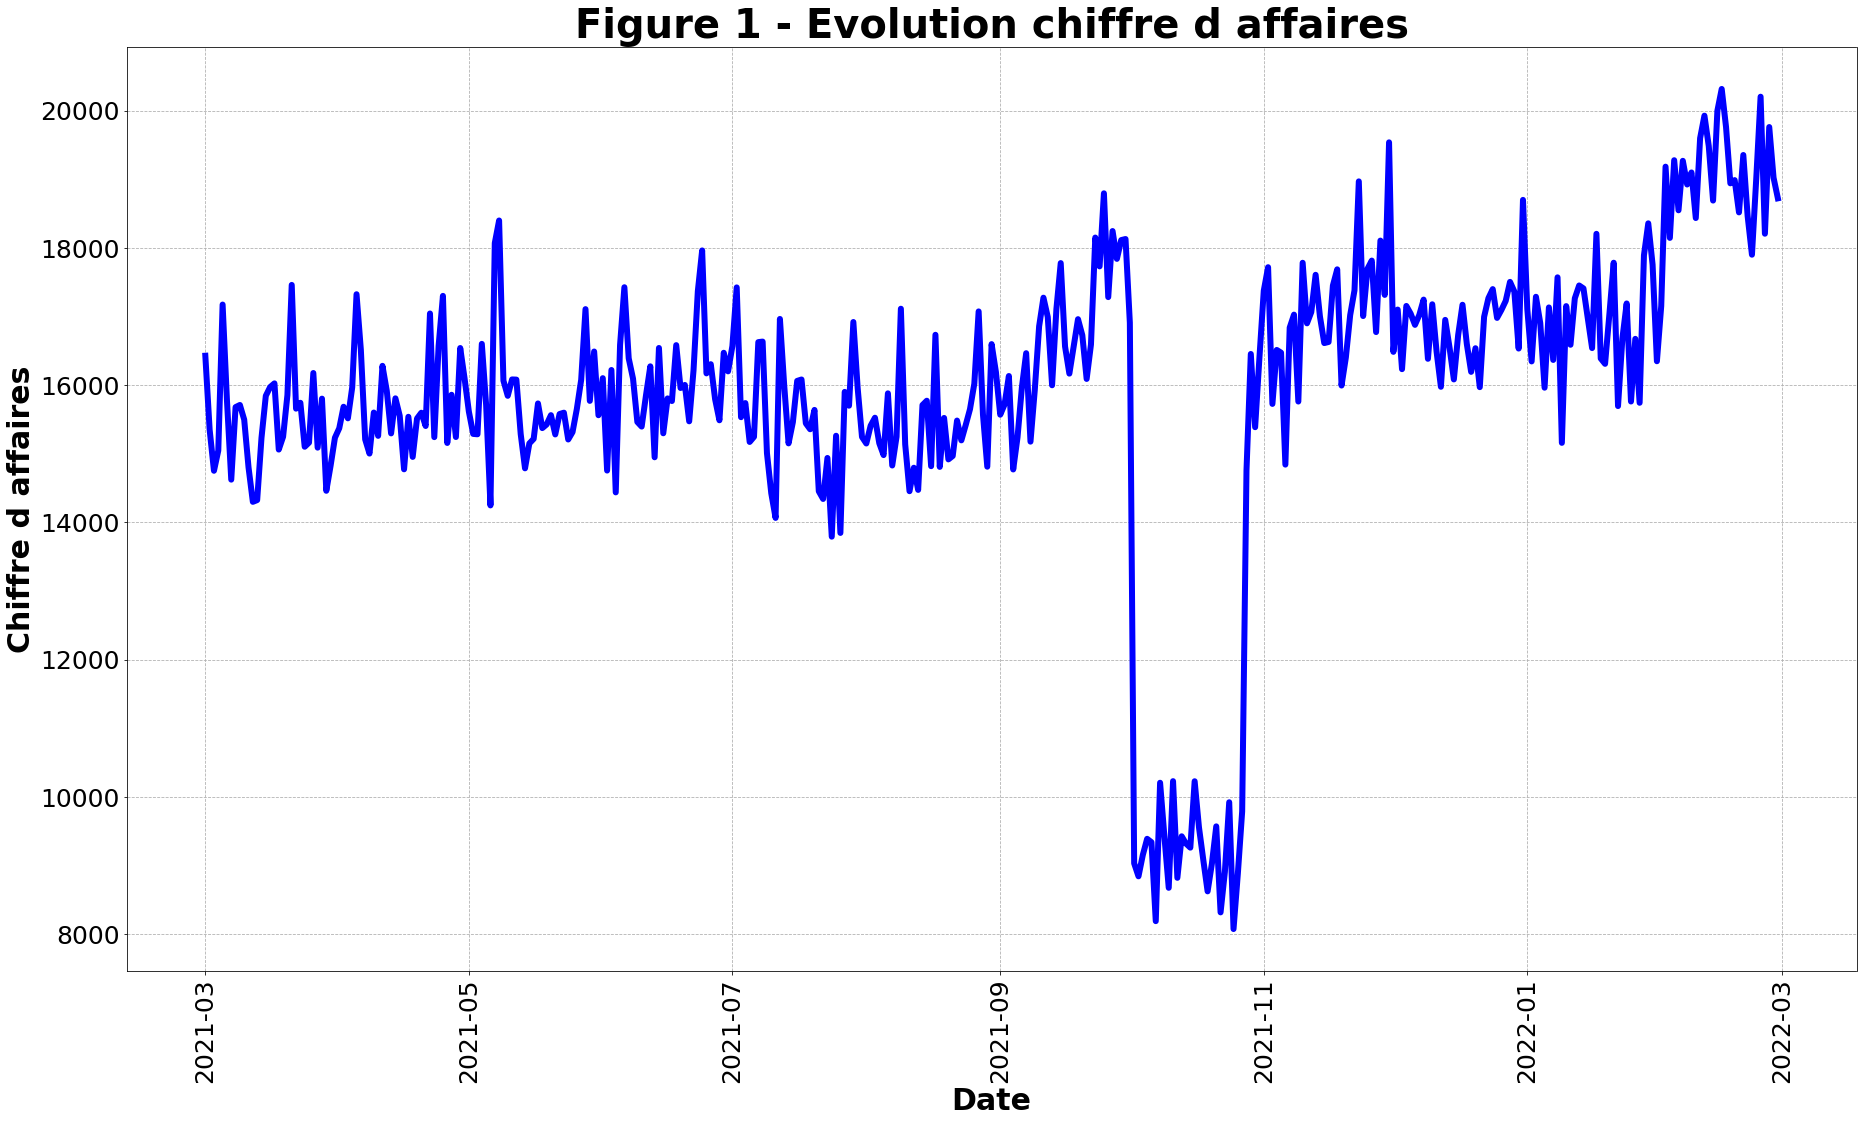

In [15]:
# x_debut : Journées écoulées depuis le début
x_debut = data.groupby(["date"])["date"].first()

# y_debut : Chiffre d'affaires par jour depuis le début pour les produits de la catégorie 0
y_debut = data.groupby(["date"])["price"].sum()

# courbe_debut : Dataframe renseignant le chiffre d'affaires par jour depuis le début
courbe_debut = pd.DataFrame([a for a in zip(y_debut,x_debut)])
courbe_debut.columns = ["price","date"]

# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.plot(courbe_debut.date, courbe_debut.price, 'b',linewidth=6)
plt.xlabel('Date',fontsize=30,fontweight = 'bold')
plt.ylabel('Chiffre d affaires',fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(rotation = 'vertical')
plt.grid(True,linestyle='--')
plt.title('Figure 1 - Evolution chiffre d affaires',fontsize=40,fontweight = 'bold')
plt.savefig('figure/Figure 1 - Evolution chiffre d affaires.png', dpi=300)
plt.show()
plt.close()

Une baisse importante a lieu au mois d'octobre 2021.

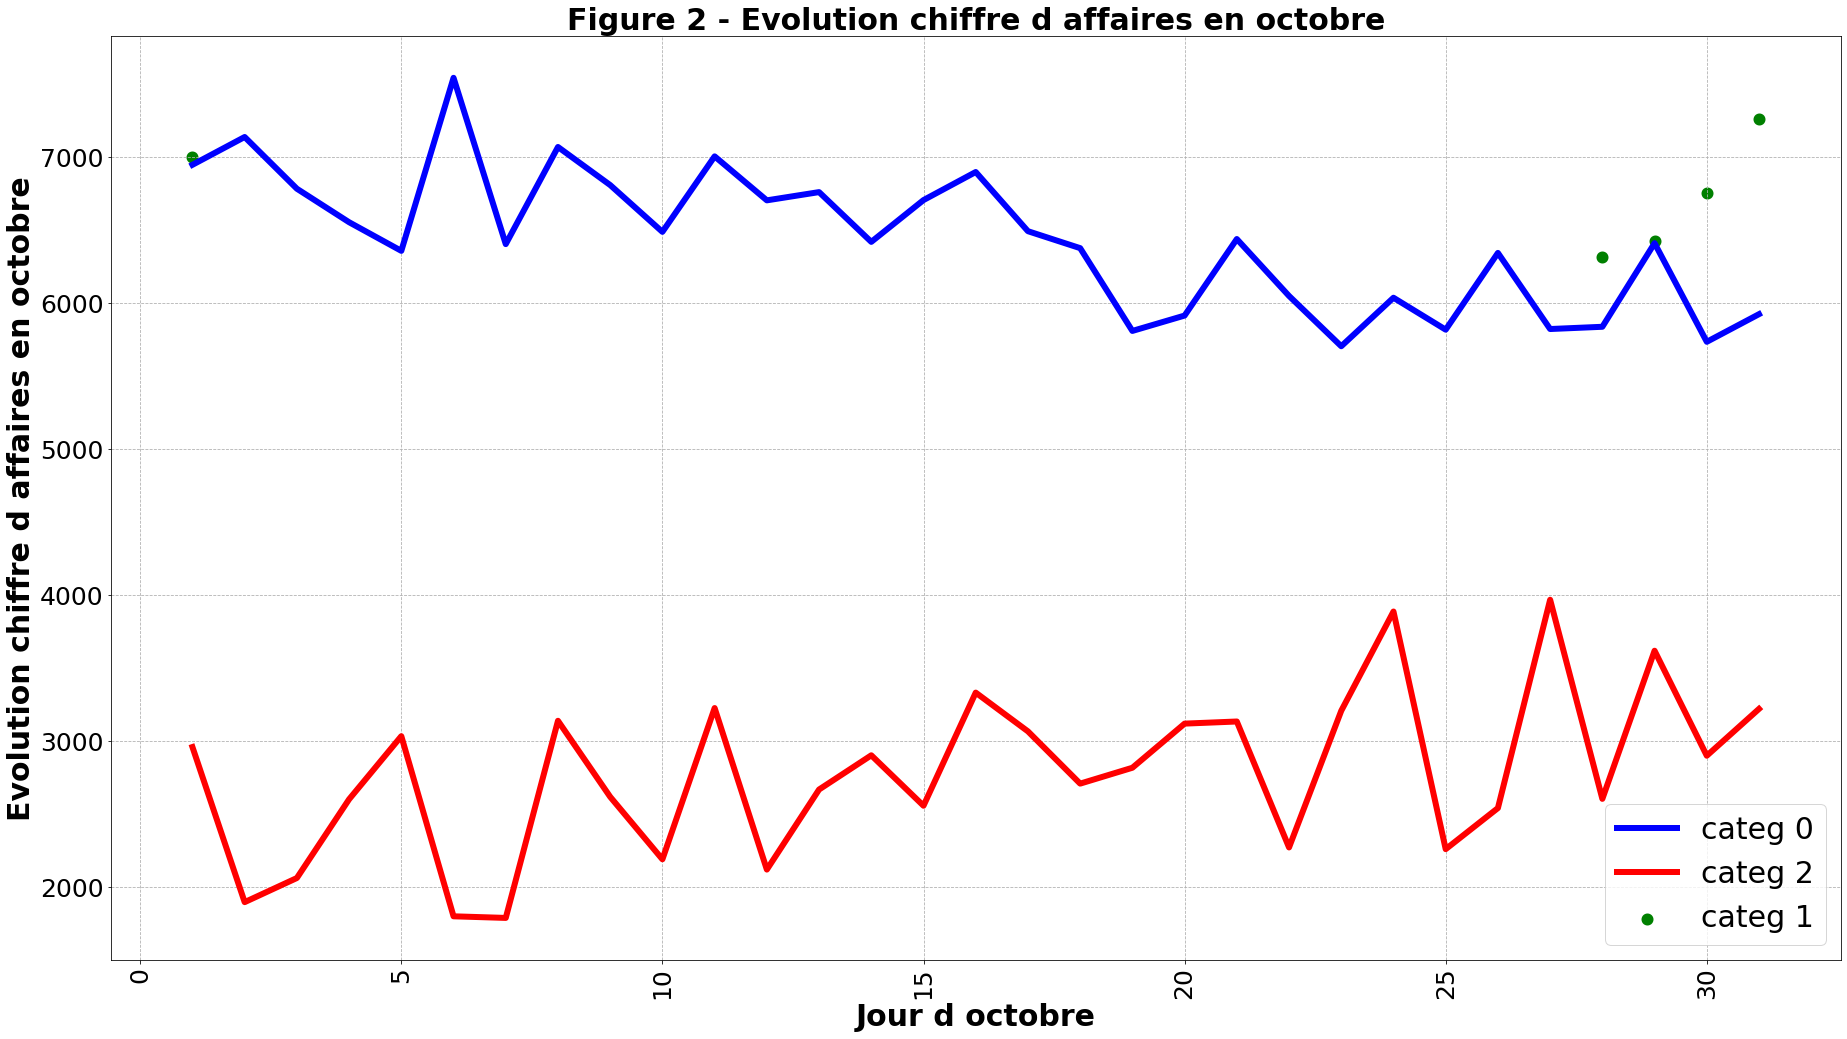

In [16]:
# octobre : Données des transactions concernant le mois d'octobre
octobre = data[data['month']==10]

# day_octobre : Jours du mois d'octobre par ordre croissant
day_octobre = octobre.groupby(["day"])["day"].first()

# day_octobre1 : Jours du mois d'octobre par ordre croissant, où des achats ont été faits pour les produits de la catégorie 1
day_octobre1 = octobre[octobre['categ']==1].groupby(["day"])["day"].first()

# y0 : Chiffre d'affaires par jour en octobre pour les produits de la catégorie 0
y0 = octobre[octobre['categ']==0].groupby(["day"])["price"].sum()
y1 = octobre[octobre['categ']==1].groupby(["day"])["price"].sum()
y2 = octobre[octobre['categ']==2].groupby(["day"])["price"].sum()

# courbe0 : Dataframe renseignant le chiffre d'affaires par jour en octobre pour les produits de la catégorie 0
courbe0 = pd.DataFrame([a for a in zip(day_octobre,y0)])
courbe0.columns = ["date","price0"]

courbe1 = pd.DataFrame([a for a in zip(day_octobre1,y1)])
courbe1.columns = ["date","price1"]

courbe2 = pd.DataFrame([a for a in zip(day_octobre,y2)])
courbe2.columns = ["date","price2"]

# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.plot(courbe0.date, courbe0.price0, 'b', label='categ 0',linewidth=6)
plt.scatter(courbe1.date, courbe1.price1.values, c='g', label='categ 1',linewidth=6)
plt.plot(courbe2.date, courbe2.price2, 'r', label='categ 2',linewidth=6)
plt.xlabel('Jour d octobre',fontsize=30,fontweight = 'bold')
plt.ylabel('Evolution chiffre d affaires en octobre',fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower right',fontsize=30)
plt.xticks(rotation = 'vertical')
plt.grid(True,linestyle='--')
plt.title('Figure 2 - Evolution chiffre d affaires en octobre',fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 2 - Evolution chiffre d affaires en octobre.png', dpi=300)
plt.show()
plt.close()

Entre le 02 octobre et le 27 octobre, aucun achat de produit de la catégorie 1 n'a été renseigné : les prix des produits de la catégorie 1 sont manquants.

#### Réalisation d'une imputation des valeurs manquantes du CA de la catégorie 1 du mois d'octobre par une régression linéaire multiple en fonction des ventes de la journée de la catégorie 0 et 2.

In [17]:
# data_imputation : Données avant non renseignement de prix pour la catégorie 1 : avant le 20-10-02
data_imputation = data[data['datetime']<='2021-10-02']

# x_imputation : Journées écoulées avant le 20-10-02
x_imputation = data_imputation.groupby(["date"])["date"].first()

# y0_imputation : Chiffre d'affaires par jour avant le 20-10-02 pour les produits de la catégorie 0
y0_imputation = data_imputation[data_imputation['categ']==0].groupby(["date"])["price"].sum()
y1_imputation = data_imputation[data_imputation['categ']==1].groupby(["date"])["price"].sum()
y2_imputation = data_imputation[data_imputation['categ']==2].groupby(["date"])["price"].sum()

# categorie0 : Dataframe renseignant le chiffre d'affaires par jour avant le 20-10-02 pour les produits de la catégorie 0
categorie0 = pd.DataFrame([a for a in zip(x_imputation,y0_imputation)])
categorie0.columns = ["date","price0"]

categorie1 = pd.DataFrame([a for a in zip(x_imputation,y1_imputation)])
categorie1.columns = ["date","price1"]

categorie2 = pd.DataFrame([a for a in zip(x_imputation,y2_imputation)])
categorie2.columns = ["date","price2"]

# data_imputation : left join de categorie0 et categorie1 sur date : conserver toutes les dates
data_imputation = pd.merge(categorie0, categorie1, on = ['date'],how='left')

# data_imputation : left join de data_imputation et categorie2 sur date :
data_imputation = pd.merge(data_imputation, categorie2, on = ['date'],how='left')

data_imputation.head()

date   price0   price1   price2
0  2021-03-01  6271.39  6811.53  3345.05
1  2021-03-02  6727.01  5627.15  2995.04
2  2021-03-03  6112.06  5691.41  2948.28
3  2021-03-04  5888.49  6098.98  3059.62
4  2021-03-05  5969.99  7071.21  4132.21

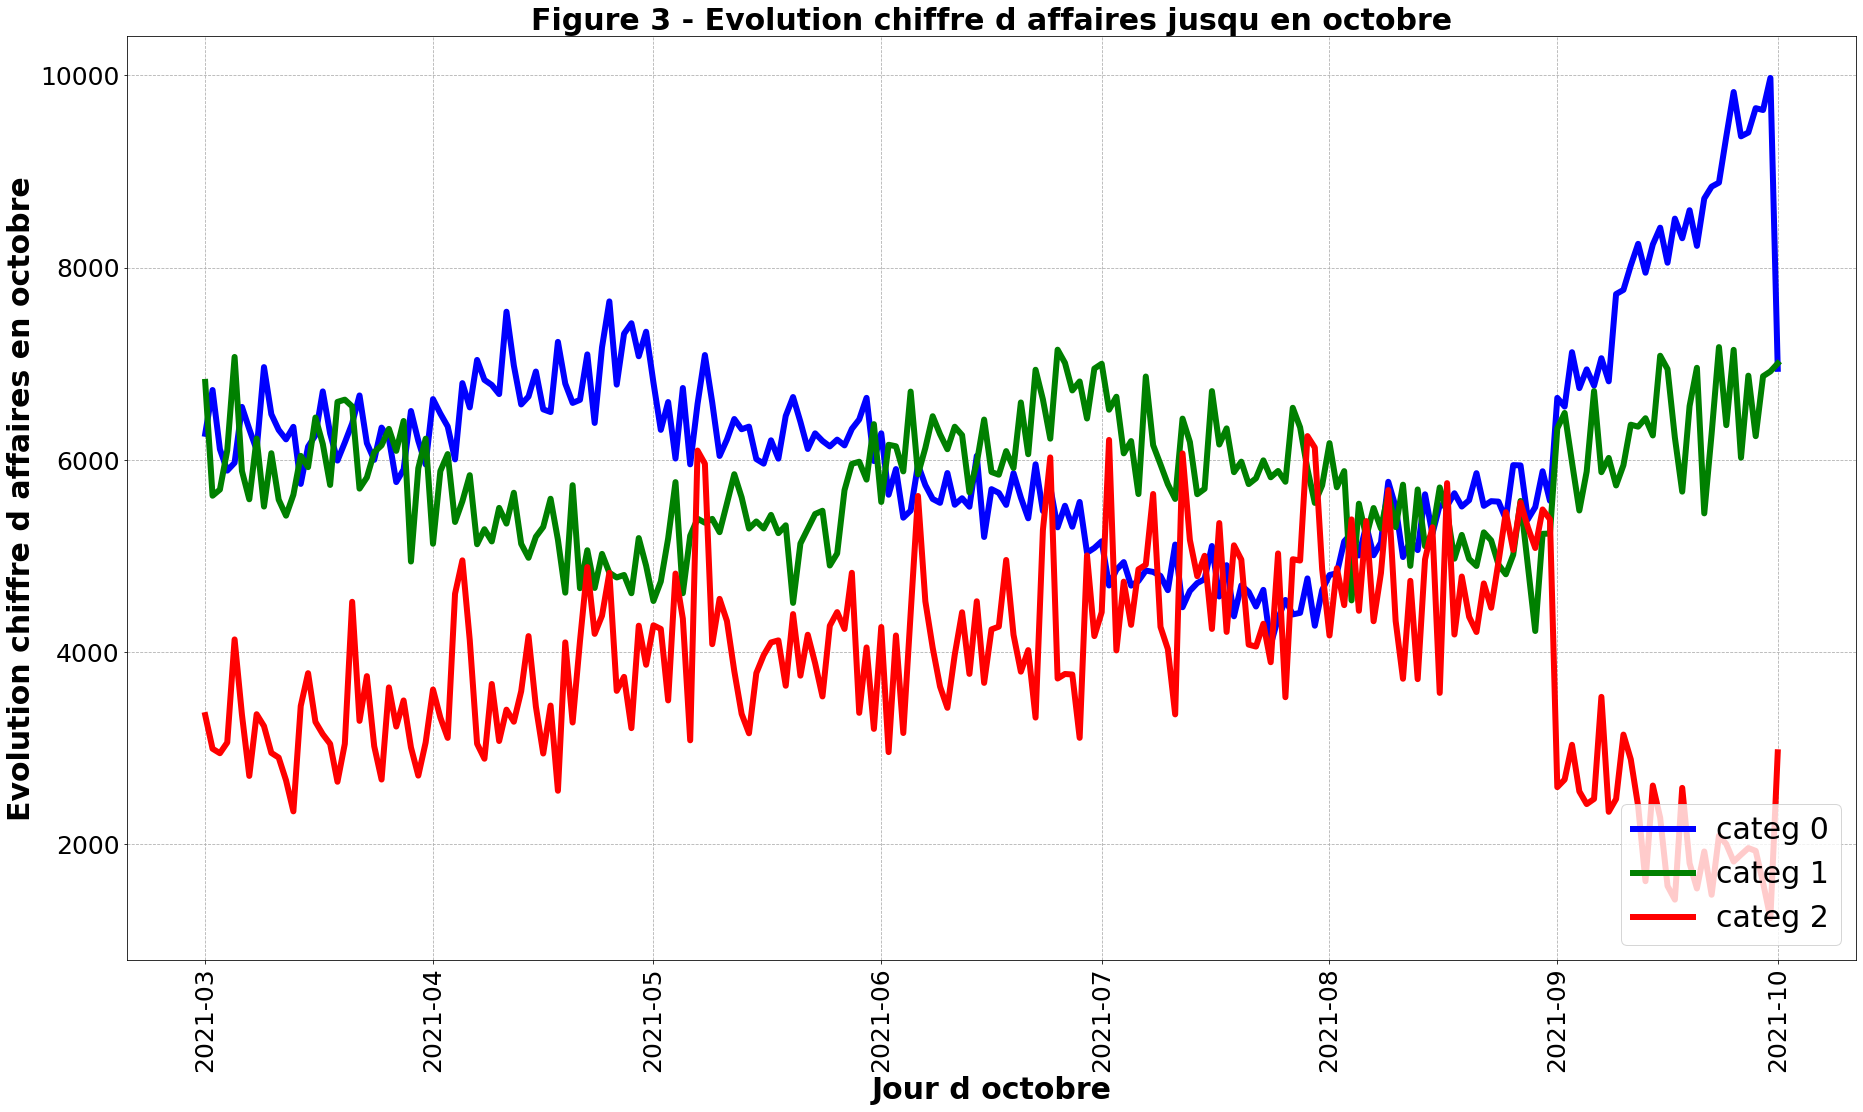

In [18]:
# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.plot(data_imputation.date, data_imputation.price0, 'b', label='categ 0',linewidth=6)
plt.plot(data_imputation.date, data_imputation.price1, c='g', label='categ 1',linewidth=6)
plt.plot(data_imputation.date, data_imputation.price2, 'r', label='categ 2',linewidth=6)
plt.xlabel('Jour d octobre',fontsize=30,fontweight = 'bold')
plt.ylabel('Evolution chiffre d affaires en octobre',fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower right',fontsize=30)
plt.xticks(rotation = 'vertical')
plt.grid(True,linestyle='--')
plt.title('Figure 3 - Evolution chiffre d affaires jusqu en octobre',fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 3 - Evolution chiffre d affaires jusqu en octobre.png', dpi=300)
plt.show()
plt.close()

In [19]:
# reg_multi : Régression linéaire multiple
reg_multi = smf.ols('price1~price0+price2', data=data_imputation).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 price1   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     18.01
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           5.96e-08
Time:                        11:35:11   Log-Likelihood:                -1675.3
No. Observations:                 215   AIC:                             3357.
Df Residuals:                     212   BIC:                             3367.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7993.2772    469.911     17.010      0.0

Le $R^{2}$ vaut 0.145, et le $R^{2}$ ajusté est d'environ 0.137 : le modèle explique faiblement la variation. Pour expliquer un CA, les variables utilisées ne suffisent pas.  
Les coefficients de price0 et price2 sont significatifs avec un intervalle de confiance de 95% car leur P-value est inférieure à 0,05.  

Malgré un faible coefficient de corrélation, c'est une imputation assez propre des données manquantes.


In [20]:
# imputation : Dataframe renseignant le chiffre d'affaires par catégorie et par jour en octobre
imputation = pd.merge(courbe0, courbe1, on = ['date'],how='left')
imputation = pd.merge(imputation, courbe2, on = ['date'],how='left')
imputation.head()

date   price0   price1   price2
0   1.0  6947.51  7003.79  2958.06
1   2.0  7138.02      NaN  1895.13
2   3.0  6783.58      NaN  2060.49
3   4.0  6554.07      NaN  2600.09
4   5.0  6357.91      NaN  3032.55

In [21]:
# Résultats de la régression linéaire multiple
b = reg_multi.params.Intercept
a0 = reg_multi.params.price0
a2 = reg_multi.params.price2

# Avec les coefficients déterminés avant le 20-10-02, les valeurs de price1 sont imputées pour les journées non renseignées d'octobre.
for i in range(1,27):
    imputation.price1[i] = a0*imputation.price0[i] + a2*imputation.price2[i] + b

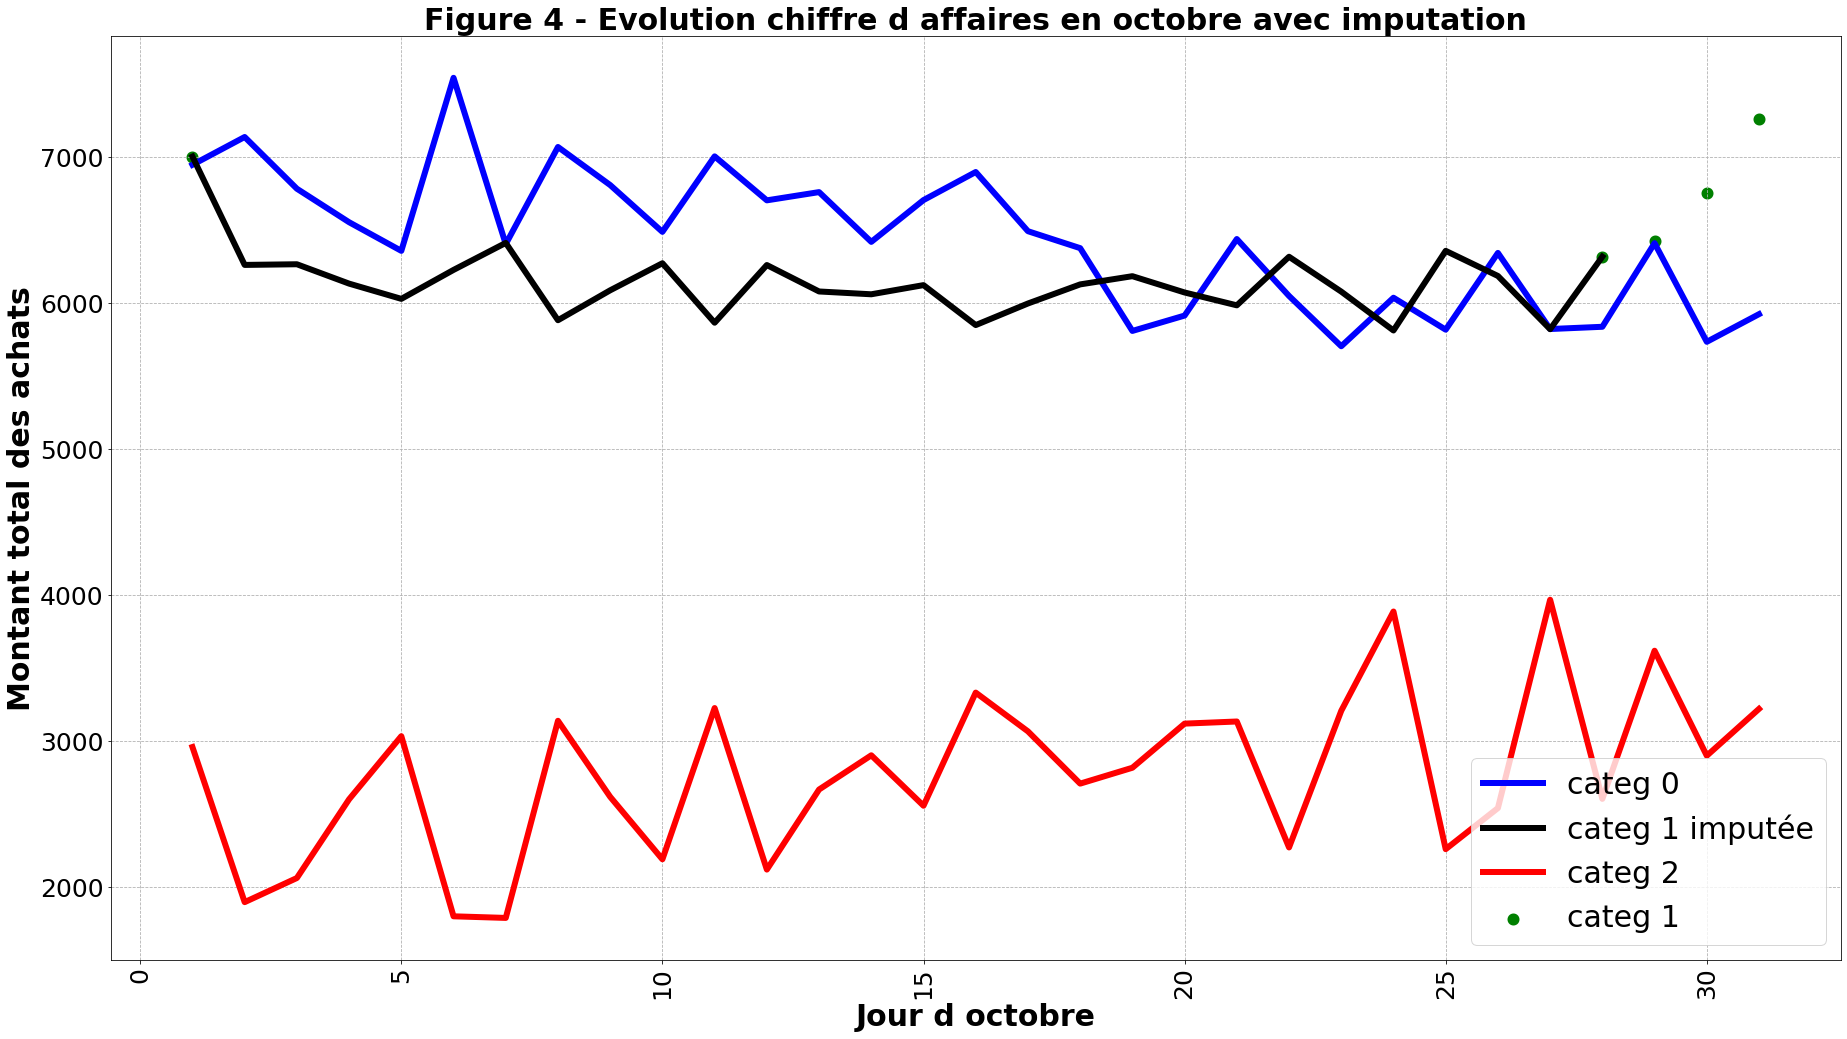

In [22]:
# date_imputation : Journée concernée par l'imputation des valeurs
date_imputation = [i for i in range (1,29)]

# price1_imputation : Valeurs du CA imputées par jour pour la catégorie 1
price1_imputation = [imputation.price1[i] for i in range(0,29)]

# courbe1_imput : Dataframe renseignant le CA imputées par jour pour la catégorie 1
courbe1_imput = pd.DataFrame([a for a in zip(date_imputation,price1_imputation)])
courbe1_imput.columns = ["date","price1"]

# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.plot(courbe0.date, courbe0.price0, 'b', label='categ 0',linewidth=6)
plt.scatter(courbe1.date, courbe1.price1.values, c='g', label='categ 1',linewidth=6)
plt.plot(courbe1_imput.date, courbe1_imput.price1, 'black', label='categ 1 imputée',linewidth=6)
plt.plot(courbe2.date, courbe2.price2, 'r', label='categ 2',linewidth=6)
plt.xlabel('Jour d octobre',fontsize=30,fontweight = 'bold')
plt.ylabel('Montant total des achats',fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower right',fontsize=30)
plt.xticks(rotation = 'vertical')
plt.grid(True,linestyle='--')
plt.title('Figure 4 - Evolution chiffre d affaires en octobre avec imputation',fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 4 - Evolution chiffre d affaires en octobre avec imputation.png', dpi=300)
plt.show()
plt.close()

## <font color=#3876C2> Mission 2 - Analyse des données </font> <a name="M2"></a>

### <font color=#FEB229> a. Analyse du chiffre d'affaires et du nombre de ventes par mois</font> <a name="M2a"></a>

#### Analyse du CA

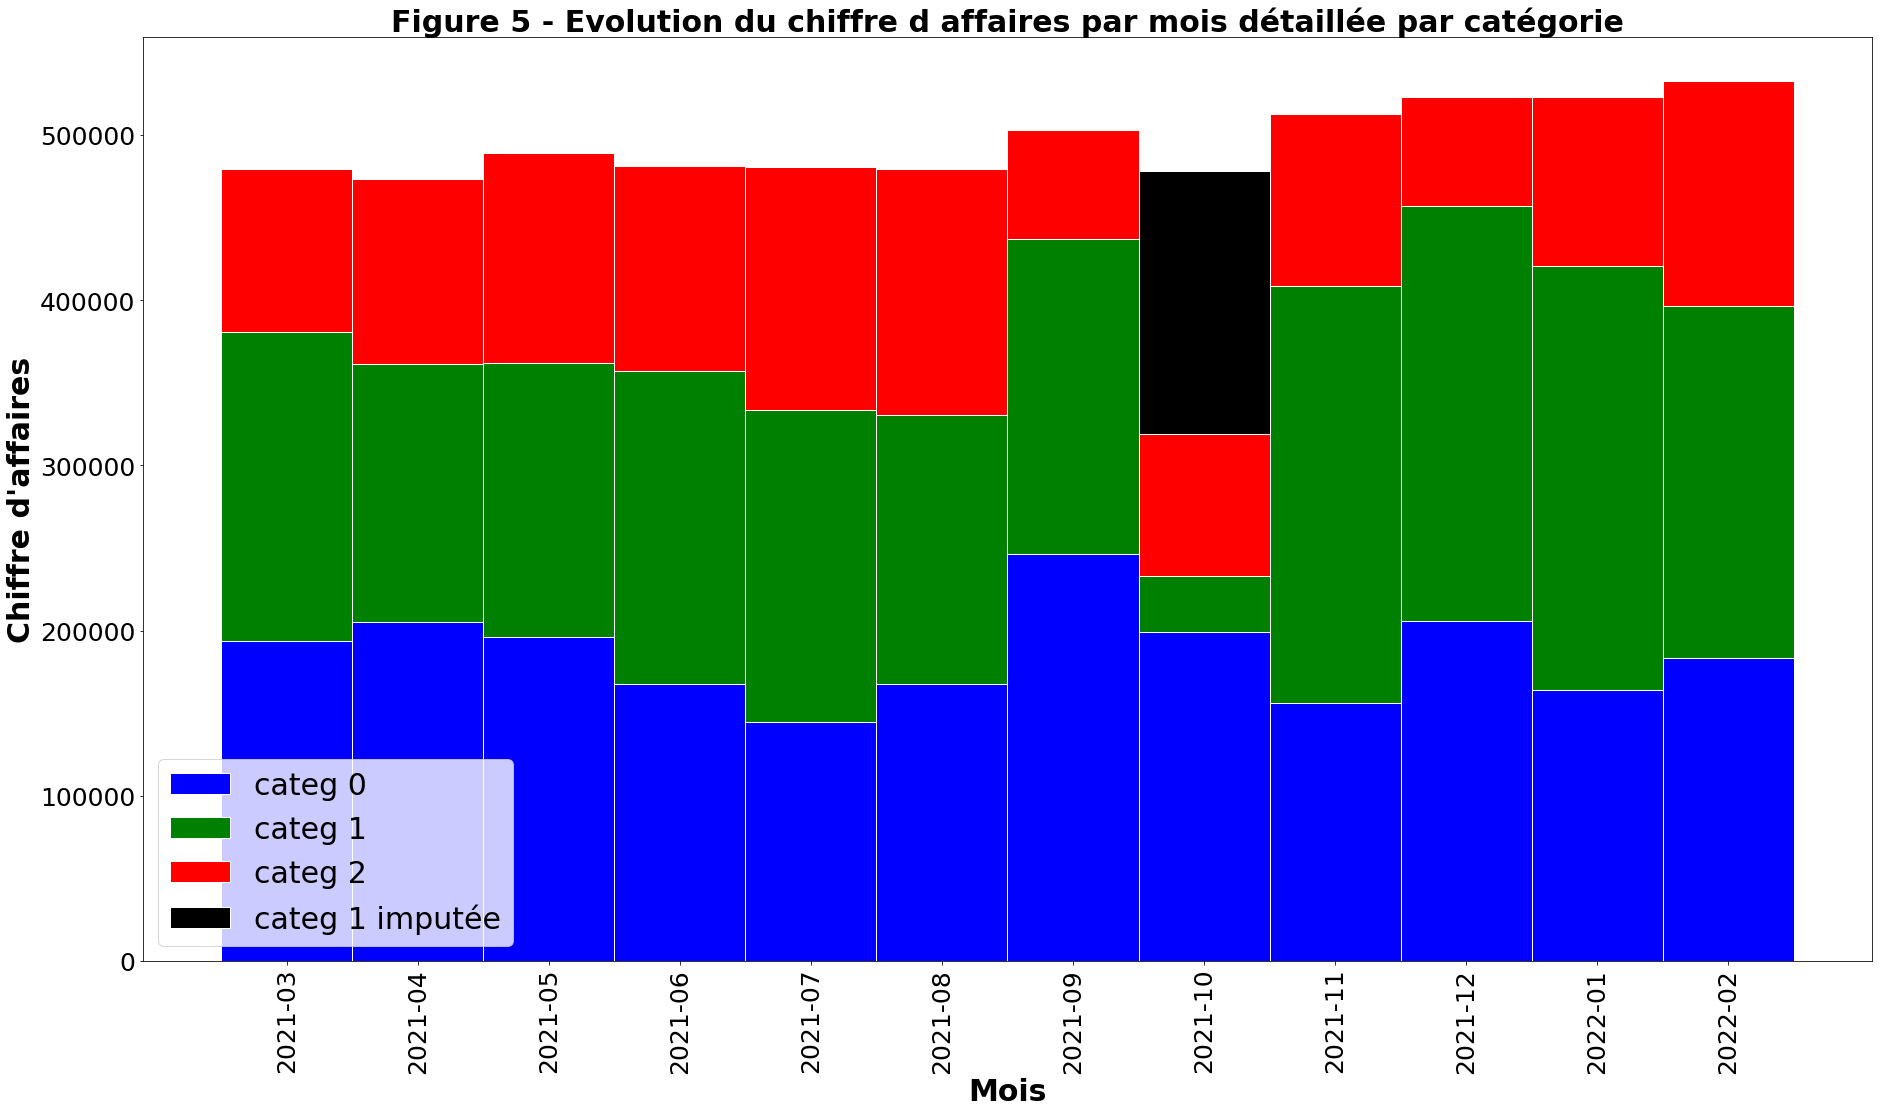

In [23]:
# x_mois : Année-Mois
x_mois = data.groupby(["yearmonth"])["yearmonth"].first().tolist()

# CA0_mois : Chiffre d'affaires par année-mois pour les produits de la catégorie 0
CA0_mois = data[data['categ']==0].groupby(["yearmonth"])["price"].sum().tolist()
CA1_mois = data[data['categ']==1].groupby(["yearmonth"])["price"].sum().tolist()
CA2_mois = data[data['categ']==2].groupby(["yearmonth"])["price"].sum().tolist()

# valeur_CA1_imputee : Valeur du chiffre d'affaires imputé pour la catégorie 1, en octobre
valeur_CA1_imputee = sum([imputation.price1[i] for i in range(1,27)]).tolist()

# Tracé de la figure

# barWidth : Largeur des barres de la figure
barWidth = 1

plt.figure(figsize = (31, 17))

# Chiffre d'affaires pour la catégorie 0
plt.bar(x_mois, CA0_mois, color='blue', edgecolor='white', width=barWidth, label='categ 0')

# Chiffre d'affaires pour la catégorie 1
plt.bar(x_mois, CA1_mois, bottom=CA0_mois, color='green', edgecolor='white', width=barWidth, label='categ 1')

# Chiffre d'affaires pour la catégorie 2
plt.bar(x_mois, CA2_mois, bottom=np.add(CA0_mois, CA1_mois).tolist(), color='red', edgecolor='white', width=barWidth, label='categ 2')
 
# Chiffre d'affaires imputé pour la catégorie 1, en octobre
plt.bar([x_mois[7]], [valeur_CA1_imputee], bottom=[CA0_mois[7]+CA1_mois[7]+CA2_mois[7]], color='black', edgecolor='white', width=barWidth, label='categ 1 imputée')

plt.xticks(rotation=90)
plt.xlabel("Mois",fontsize=30,fontweight = 'bold')
plt.ylabel("Chiffre d'affaires",fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left",fontsize=30)
plt.title("Figure 5 - Evolution du chiffre d affaires par mois détaillée par catégorie",fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 5 - Evolution du chiffre d affaires par mois détaillée catégorie.png', dpi=300)
plt.show()
plt.close()

Des données sont manquantes : nous les simulons en imputant les données manquantes par régression multiple.
L'imputation semble minorer le chiffre d'affaires. En effet, la baisse du chiffre d'affaires les deux premiers mois semblent influencer le résultat.


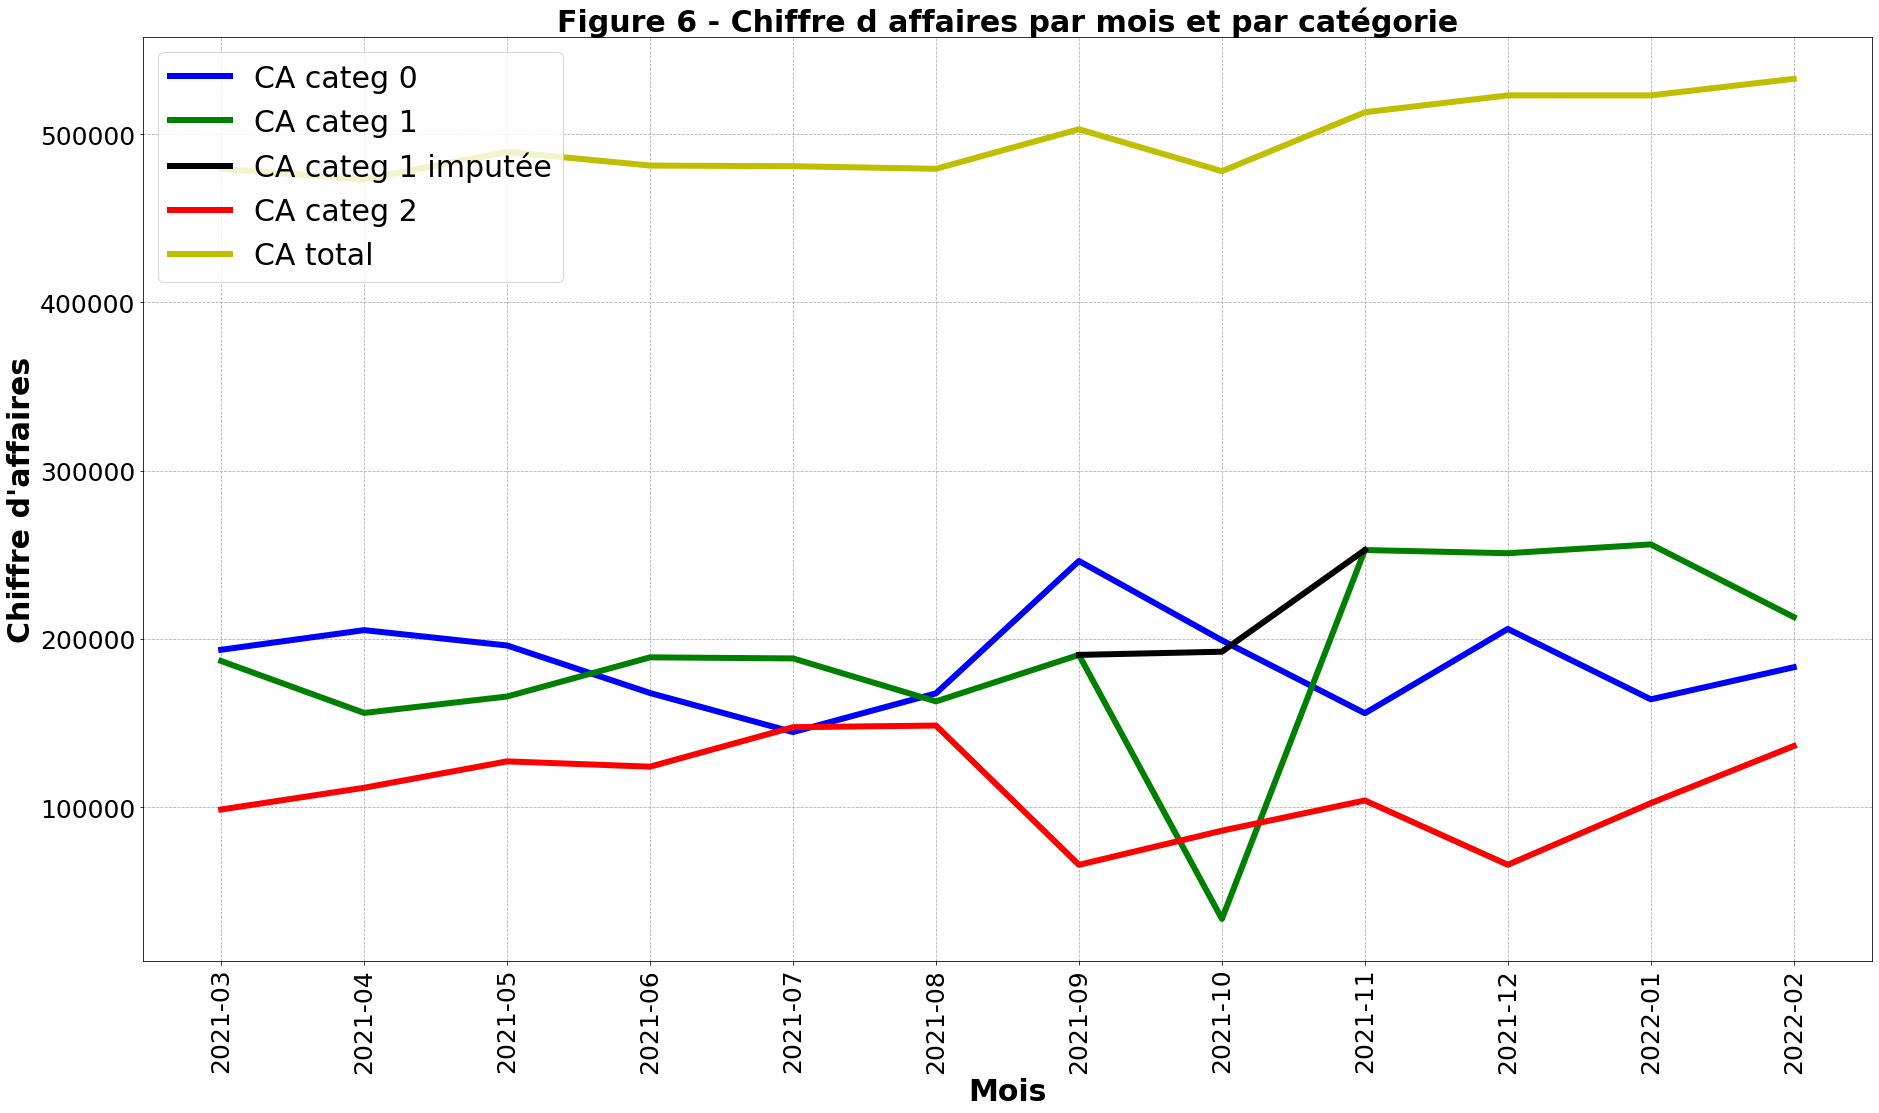

In [24]:
# Tracé de la figure
plt.figure(figsize = (31, 17))

# Chiffre d'affaires pour la catégorie 0
plt.plot(x_mois, CA0_mois, color='blue', label='CA categ 0',linewidth=6)

# Chiffre d'affaires pour la catégorie 1, sans imputation du mois d'octobre
plt.plot(x_mois, CA1_mois, color='green', label='CA categ 1',linewidth=6)

# Chiffre d'affaires pour la catégorie 1, avec imputation du mois d'octobre
x_mois_imput = [x_mois[6],x_mois[7],x_mois[8]]
CA1_mois_imput = [CA1_mois[6],CA1_mois[7]+valeur_CA1_imputee,CA1_mois[8]]
plt.plot(x_mois_imput, CA1_mois_imput, color='black', label='CA categ 1 imputée',linewidth=6)

# Chiffre d'affaires pour la catégorie 2
plt.plot(x_mois, CA2_mois, color='red', label='CA categ 2',linewidth=6)
    
# Chiffre d'affaires total, avec imputation du mois d'octobre
CA_012 = [CA0_mois[i]+CA1_mois[i]+CA2_mois[i] for i in range(0,12)]
CA_012[7] = CA_012[7]+valeur_CA1_imputee
plt.plot(x_mois, CA_012 , color='y', label='CA total',linewidth=6)

# Custom X axis
plt.xticks(rotation=90,fontsize=25)
plt.xlabel("Mois",fontsize=30,fontweight = 'bold')
plt.ylabel("Chiffre d'affaires",fontsize=30,fontweight = 'bold')
plt.yticks(fontsize=25)
plt.legend(loc="upper left",fontsize=30)
plt.grid(True,linestyle='--')
plt.title("Figure 6 - Chiffre d affaires par mois et par catégorie",fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 6 - Chiffre d affaires par mois et par catégorie.png', dpi=300)
plt.show()
plt.close()

En regardant le détail par catégorie, on observe que la stabilité du chiffre d'affaires est dûe à la compensation des catégories :
- Lorsque le CA de la catégorie 0 diminue, celui de la catégorie 2 augmente.
- Il semblerait alors que le CA total suive l'allure du CA de la catégorie 1.

#### Analyse du nombre de ventes

In [25]:
# nb_ventes_mois_012 : Nombre de ventes par mois
nb_ventes_mois_012 = data.yearmonth.value_counts().sort_index()
nb_ventes_mois_0 = data[data['categ']==0].yearmonth.value_counts().sort_index()
nb_ventes_mois_1 = data[data['categ']==1].yearmonth.value_counts().sort_index()
nb_ventes_mois_2 = data[data['categ']==2].yearmonth.value_counts().sort_index()

# nb_ventes_mois_012 : Dataframe renseignant le nombre de ventes par mois
nb_ventes_mois_012 = pd.DataFrame([a for a in zip(x_mois,nb_ventes_mois_012)])
nb_ventes_mois_0 = pd.DataFrame([a for a in zip(x_mois,nb_ventes_mois_0)])
nb_ventes_mois_1 = pd.DataFrame([a for a in zip(x_mois,nb_ventes_mois_1)])
nb_ventes_mois_2 = pd.DataFrame([a for a in zip(x_mois,nb_ventes_mois_2)])

nb_ventes_mois_012.columns = ["month","nb_ventes012"]
nb_ventes_mois_0.columns = ["month","nb_ventes0"]
nb_ventes_mois_1.columns = ["month","nb_ventes1"]
nb_ventes_mois_2.columns = ["month","nb_ventes2"]

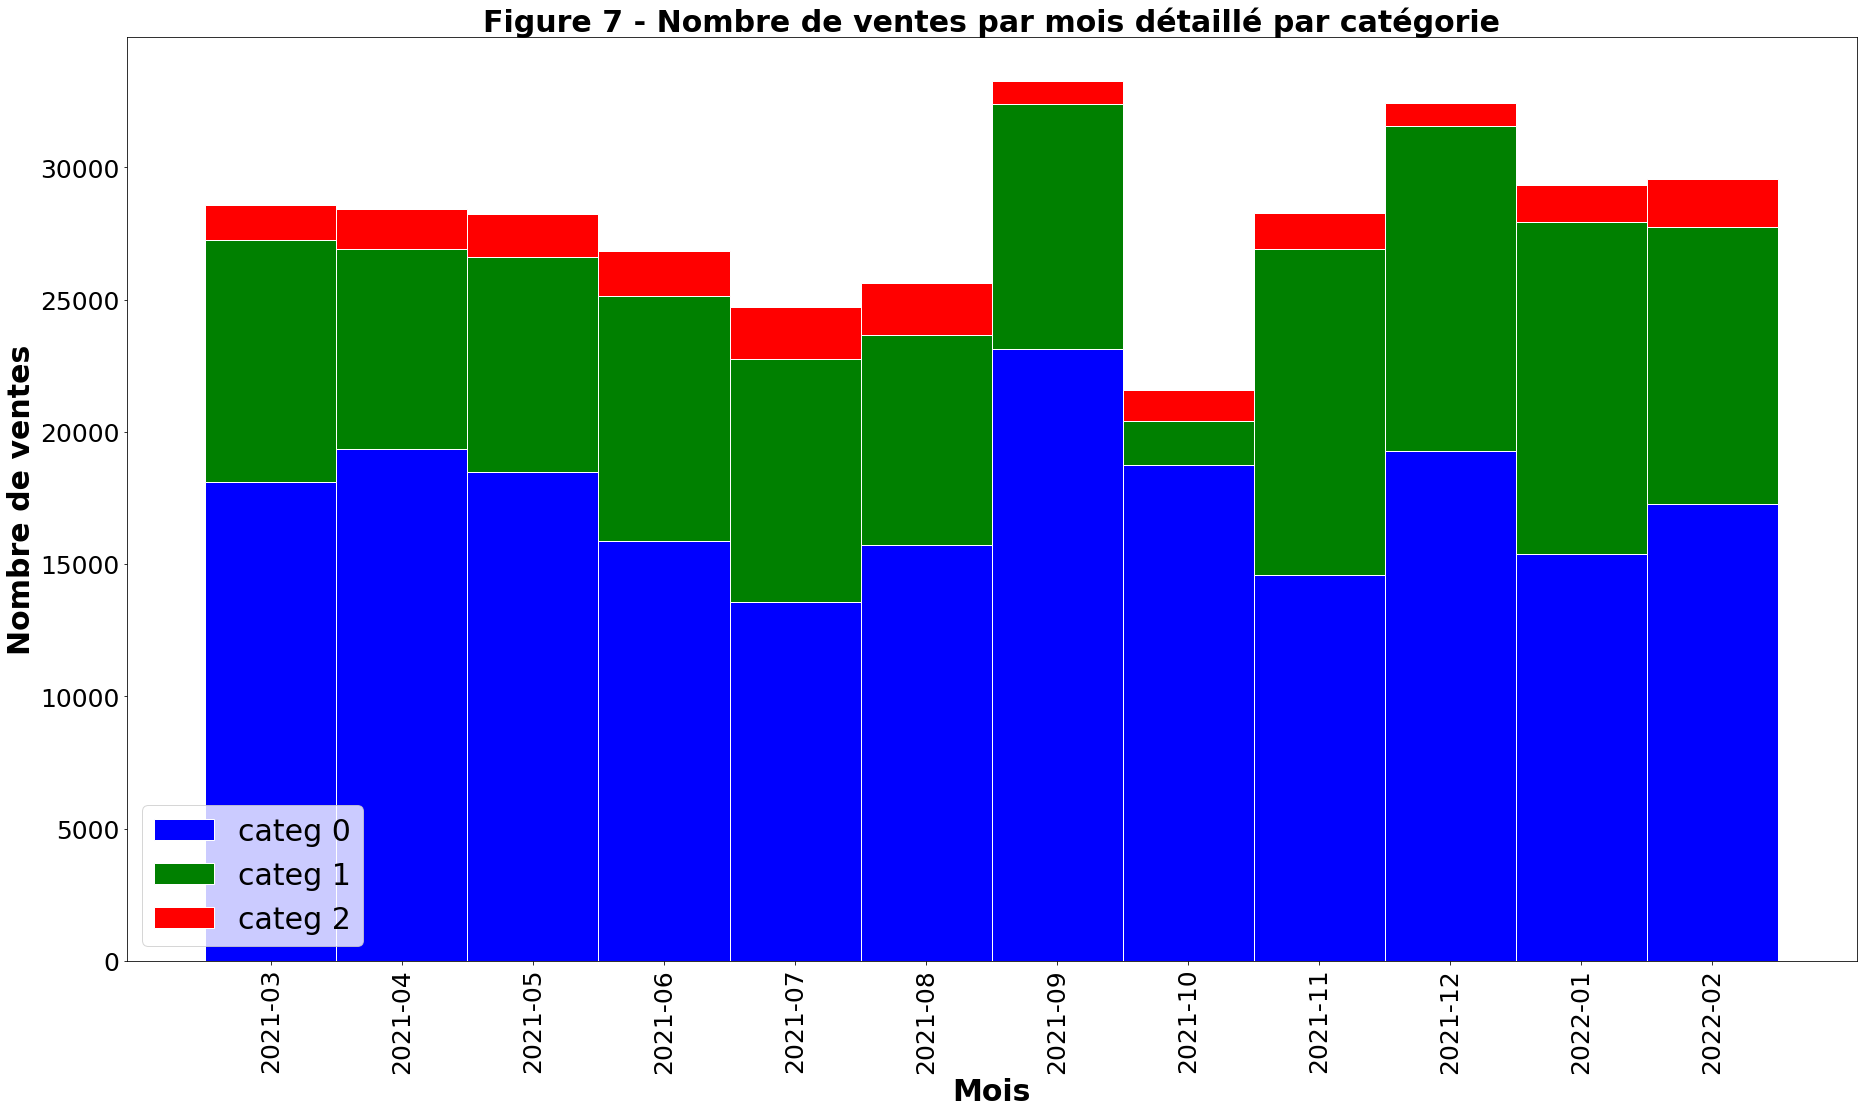

In [26]:
# barWidth : Largeur des barres de la figure
barWidth = 1

plt.figure(figsize = (31, 17))

# Nombre de ventes pour la catégorie 0
plt.bar(x_mois, nb_ventes_mois_0.nb_ventes0, color='blue', edgecolor='white', width=barWidth, label='categ 0')

# Nombre de ventes pour la catégorie 1
plt.bar(x_mois, nb_ventes_mois_1.nb_ventes1, bottom=nb_ventes_mois_0.nb_ventes0, color='green', edgecolor='white', width=barWidth, label='categ 1')

# Nombre de ventes pour la catégorie 2
plt.bar(x_mois, nb_ventes_mois_2.nb_ventes2, bottom=np.add(nb_ventes_mois_0.nb_ventes0, nb_ventes_mois_1.nb_ventes1).tolist(), color='red', edgecolor='white', width=barWidth, label='categ 2')

plt.xticks(rotation=90)
plt.xlabel("Mois",fontsize=30,fontweight = 'bold')
plt.ylabel("Nombre de ventes",fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left",fontsize=30)
plt.title("Figure 7 - Nombre de ventes par mois détaillé par catégorie",fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 7 - Nombre de ventes par mois détaillé par catégorie.png', dpi=300)
plt.show()
plt.close()

Entre le 02 octobre et le 27 octobre, aucun achat de produit de la catégorie 1 n'a été renseigné : des produits de la catégorie 1 sont manquants.
Une imputation pour le nombre de ventes de la catégorie 1 du mois d'octobre est faite par régression linéaire multiple en fonction du nombre de ventes par mois des produits des catégories 0 et 2.

In [27]:
# data_imputation_nb_ventes : Nombre de ventes par catégorie et par mois, avant octobre 2021
data_imputation_nb_ventes = pd.merge(nb_ventes_mois_0, nb_ventes_mois_1, on = ['month'],how='left')
data_imputation_nb_ventes = pd.merge(data_imputation_nb_ventes, nb_ventes_mois_2, on = ['month'],how='left')
data_imputation_nb_ventes = data_imputation_nb_ventes[data_imputation_nb_ventes['month']<='2021-09']
data_imputation_nb_ventes

month  nb_ventes0  nb_ventes1  nb_ventes2
0  2021-03       18119        9134        1315
1  2021-04       19335        7579        1501
2  2021-05       18485        8107        1653
3  2021-06       15886        9264        1669
4  2021-07       13569        9169        1978
5  2021-08       15717        7954        1948
6  2021-09       23124        9268         874

In [28]:
# reg_multi_ventes : Régression linéaire multiple
reg_multi_ventes = smf.ols('nb_ventes1~nb_ventes0+nb_ventes2', data=data_imputation_nb_ventes).fit()
print(reg_multi_ventes.summary())

                            OLS Regression Results                            
Dep. Variable:             nb_ventes1   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     7.335
Date:                Sat, 11 Jan 2020   Prob (F-statistic):             0.0459
Time:                        11:35:34   Log-Likelihood:                -50.142
No. Observations:                   7   AIC:                             106.3
Df Residuals:                       4   BIC:                             106.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.449e+04   4217.070      5.807      0.0

/Users/stephanenedelec/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


Le $R^{2}$ vaut 0.786, et le $R^{2}$ ajusté est d'environ 0.679 : le modèle explique bien la variation.
Les coefficients de nb_ventes0 et nb_ventes2 sont significatifs avec un intervalle de confiance de 95% car leur P-value est inférieure à 0,05.

In [29]:
# Résultats de la régression linéaire multiple
c = reg_multi_ventes.params.Intercept
d0 = reg_multi_ventes.params.nb_ventes0
d2 = reg_multi_ventes.params.nb_ventes2

# valeur_nb_ventes_imputee : Valeur du nombre de vente ajoutée pour le mois d'octobre
valeur_nb_ventes_imputee = round(nb_ventes_mois_0.nb_ventes0[7]*d0 + nb_ventes_mois_2.nb_ventes2[7]*d2 + c) - nb_ventes_mois_1.nb_ventes1[7]

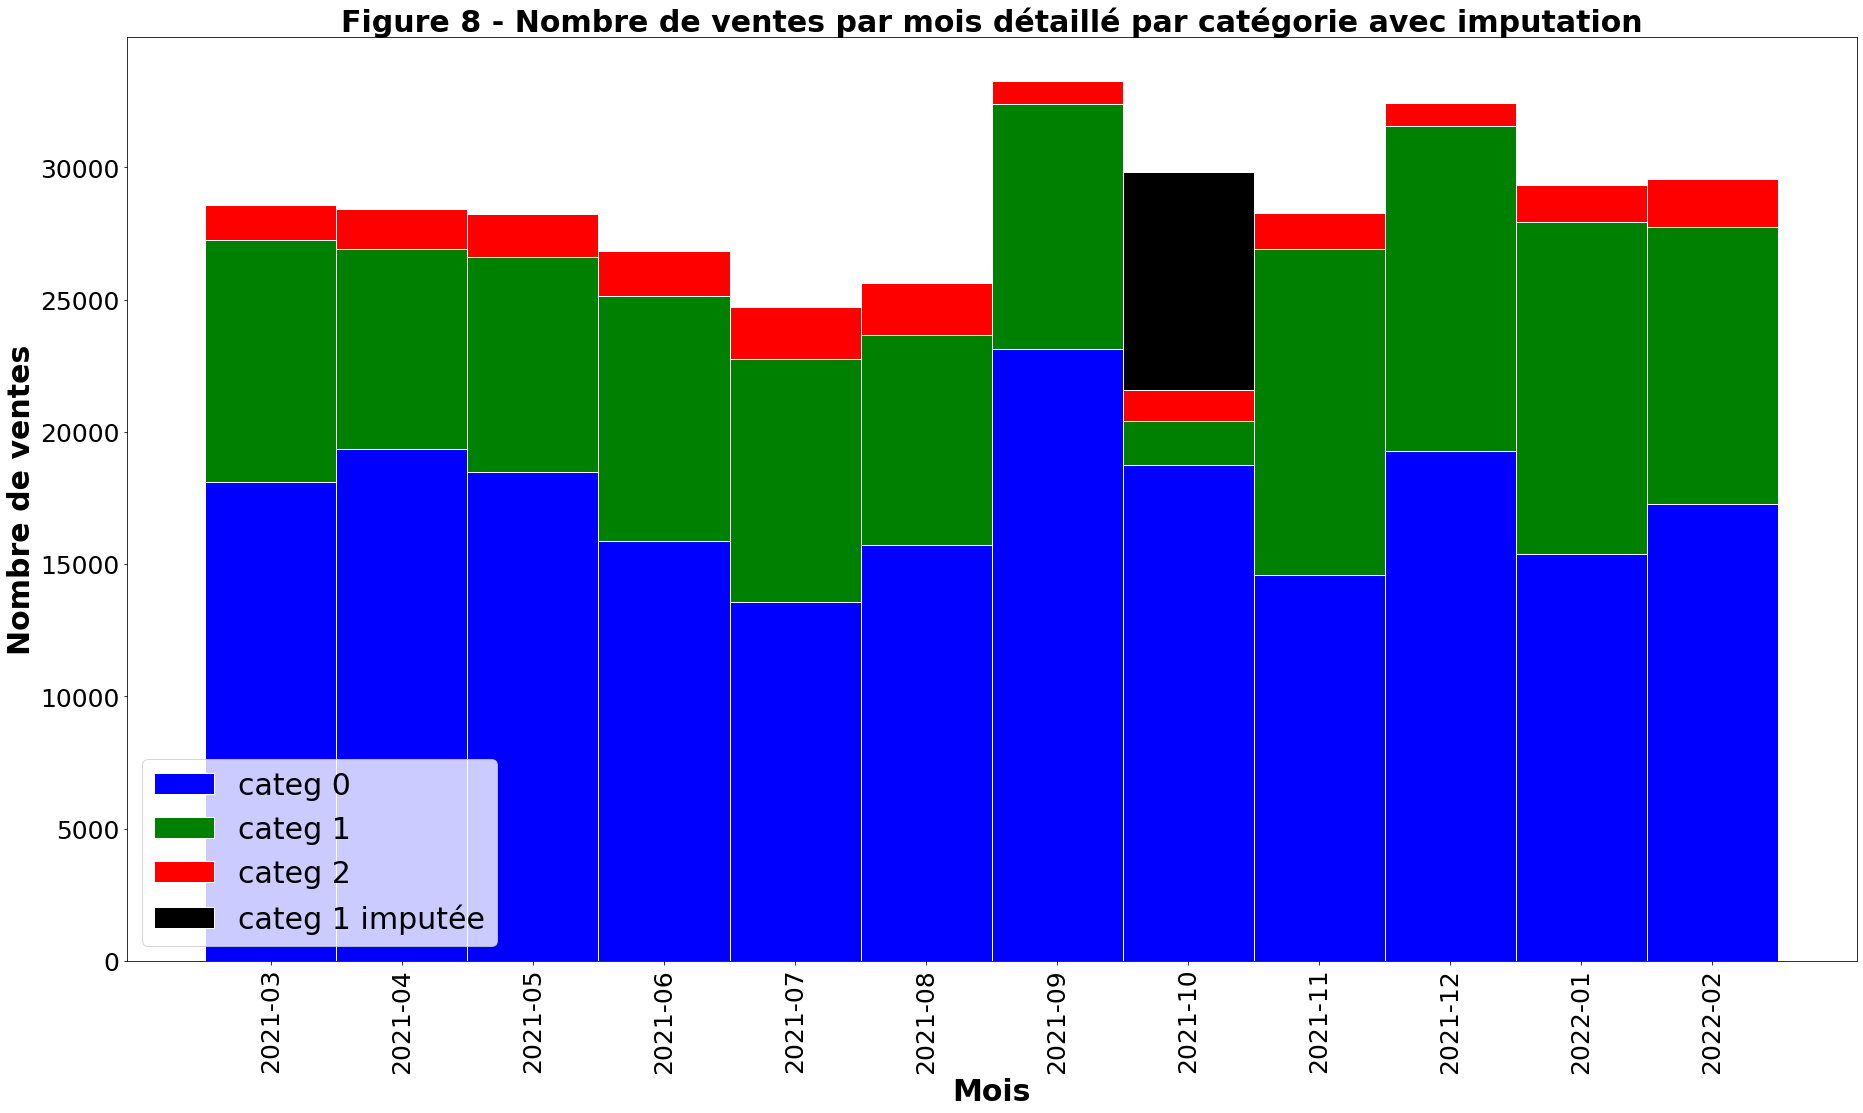

In [30]:
# barWidth : Largeur des barres de la figure
barWidth = 1

plt.figure(figsize = (31, 17))

# Nombre de ventes pour la catégorie 0

plt.bar(x_mois, nb_ventes_mois_0.nb_ventes0, color='blue', edgecolor='white', width=barWidth, label='categ 0')

# Nombre de ventes pour la catégorie 1
plt.bar(x_mois, nb_ventes_mois_1.nb_ventes1, bottom=nb_ventes_mois_0.nb_ventes0, color='green', edgecolor='white', width=barWidth, label='categ 1')

# Nombre de ventes pour la catégorie 2
plt.bar(x_mois, nb_ventes_mois_2.nb_ventes2, bottom=np.add(nb_ventes_mois_0.nb_ventes0, nb_ventes_mois_1.nb_ventes1).tolist(), color='red', edgecolor='white', width=barWidth, label='categ 2')
 
# Nombre de ventes imputé pour la catégorie 1 en octonbre
plt.bar([x_mois[7]], [valeur_nb_ventes_imputee], bottom=[nb_ventes_mois_0.nb_ventes0[7]+nb_ventes_mois_1.nb_ventes1[7]+nb_ventes_mois_2.nb_ventes2[7]], color='black', edgecolor='white', width=barWidth, label='categ 1 imputée')
    
plt.xticks(rotation=90)
plt.xlabel("Mois",fontsize=30,fontweight = 'bold')
plt.ylabel("Nombre de ventes",fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left",fontsize=30)
plt.title("Figure 8 - Nombre de ventes par mois détaillé par catégorie avec imputation",fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 8 - Nombre de ventes par mois détaillé par catégorie avec imputation.png', dpi=300)
plt.show()
plt.close()

Une baisse est observée entre mars 2021 et août 2021. Un pic se situe en septembre 2021 (rentrée scolaire). Un autre pic se situe en décembre 2021 (période de fêtes : Noël).

### <font color=#FEB229> b. Analyse des clients qui génèrent le plus de chiffre d'affaires</font> <a name="M2b"></a>

In [31]:
# CA_client : Chiffre d'affaires par client
CA_client = data.groupby(["client_id"])["price"].sum()
client = data.groupby(["client_id"])["client_id"].first()
CA_client = pd.DataFrame([a for a in zip(client,CA_client)])
CA_client.columns = ["client_id","price"]
CA_client.sort_values(by='price', ascending=False).head(10)

client_id      price
677     c_1609  162007.34
4388    c_4958  144257.21
6337    c_6714   73220.80
2724    c_3454   54466.38
7715    c_7959    2564.25
7791    c_8026    2549.40
3870    c_4491    2540.53
1268    c_2140    2527.01
8195    c_8392    2515.98
7120    c_7421    2511.98

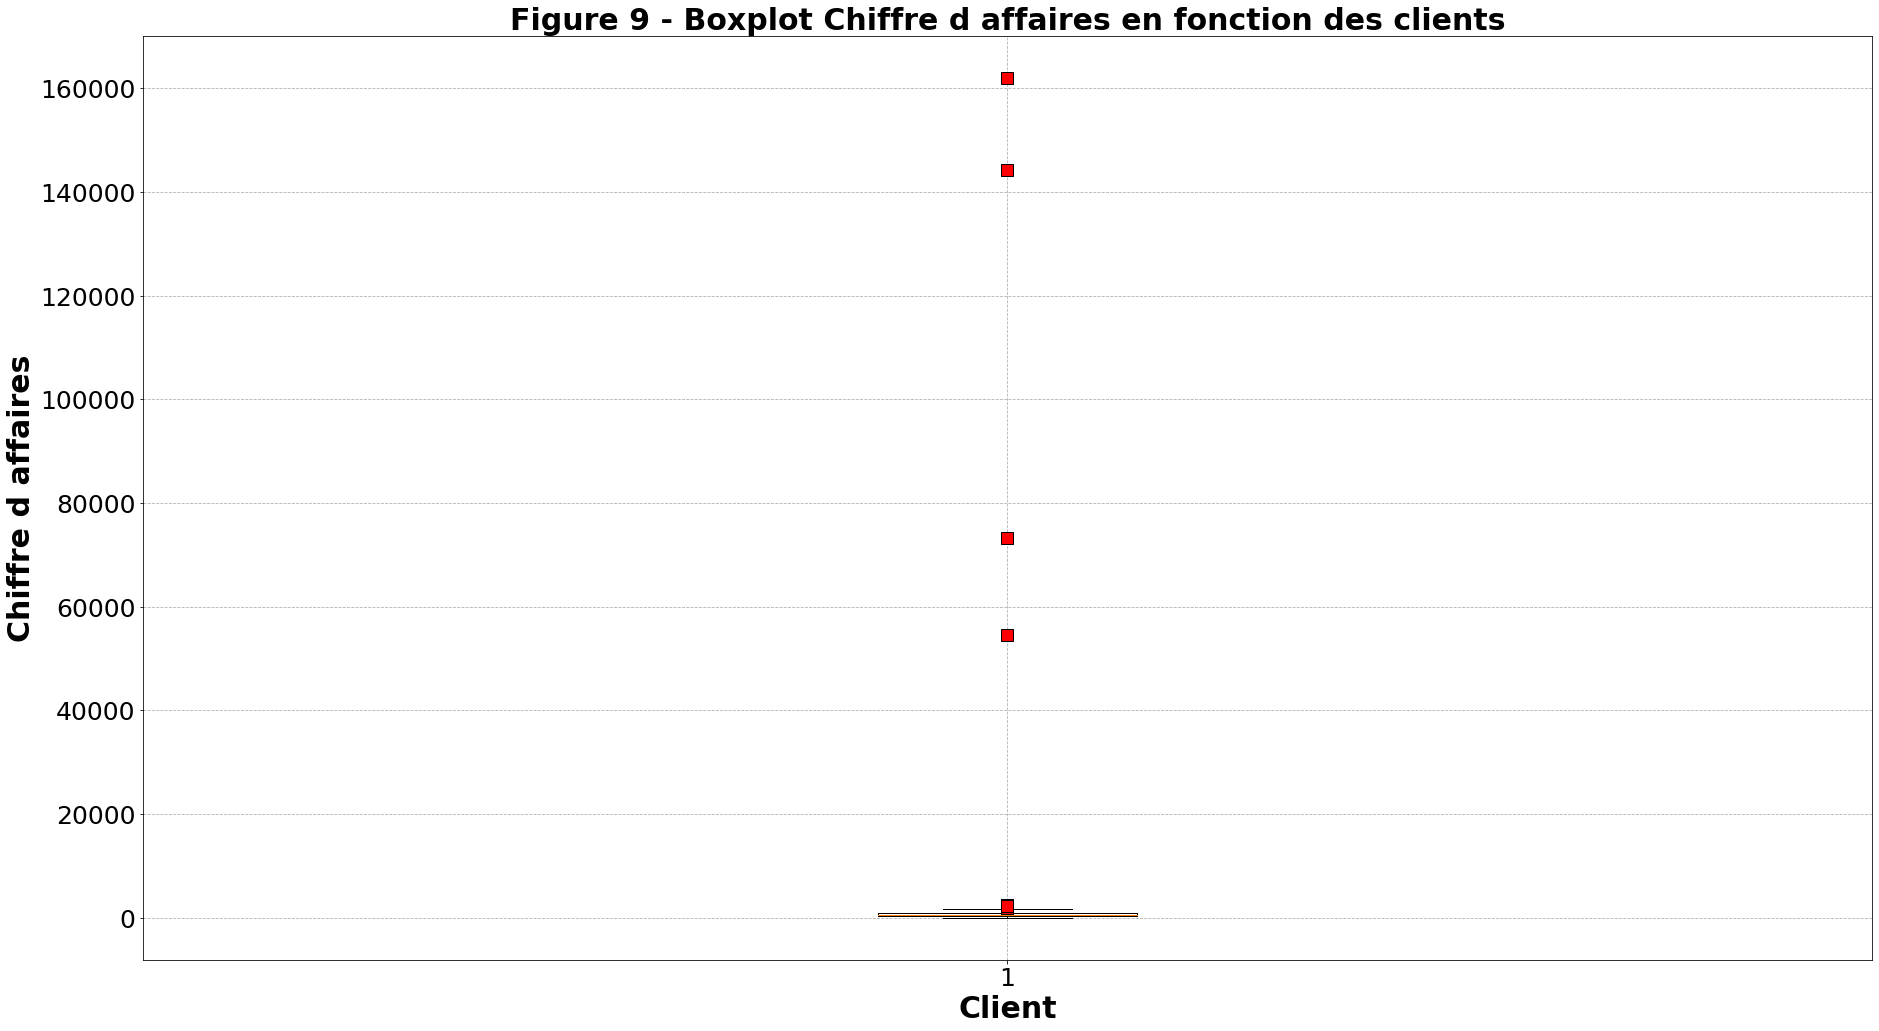

In [32]:
# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.boxplot(CA_client['price'].tolist(),flierprops=dict(markerfacecolor='r', marker='s',markersize=12))
plt.xlabel("Client",fontsize=30,fontweight = 'bold')
plt.ylabel("Chiffre d affaires",fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True,linestyle='--')
plt.title("Figure 9 - Boxplot Chiffre d affaires en fonction des clients",fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 9 - Boxplot Chiffre d affaires en fonction des clients.png', dpi=300)
plt.show()
plt.close()

4 clients sont atypiques : "Super clients"
- c_1609  
- c_4958  
- c_6714  
- c_3454  

#### Pourcentage du CA en fonction du pourcentage de clients acheteurs

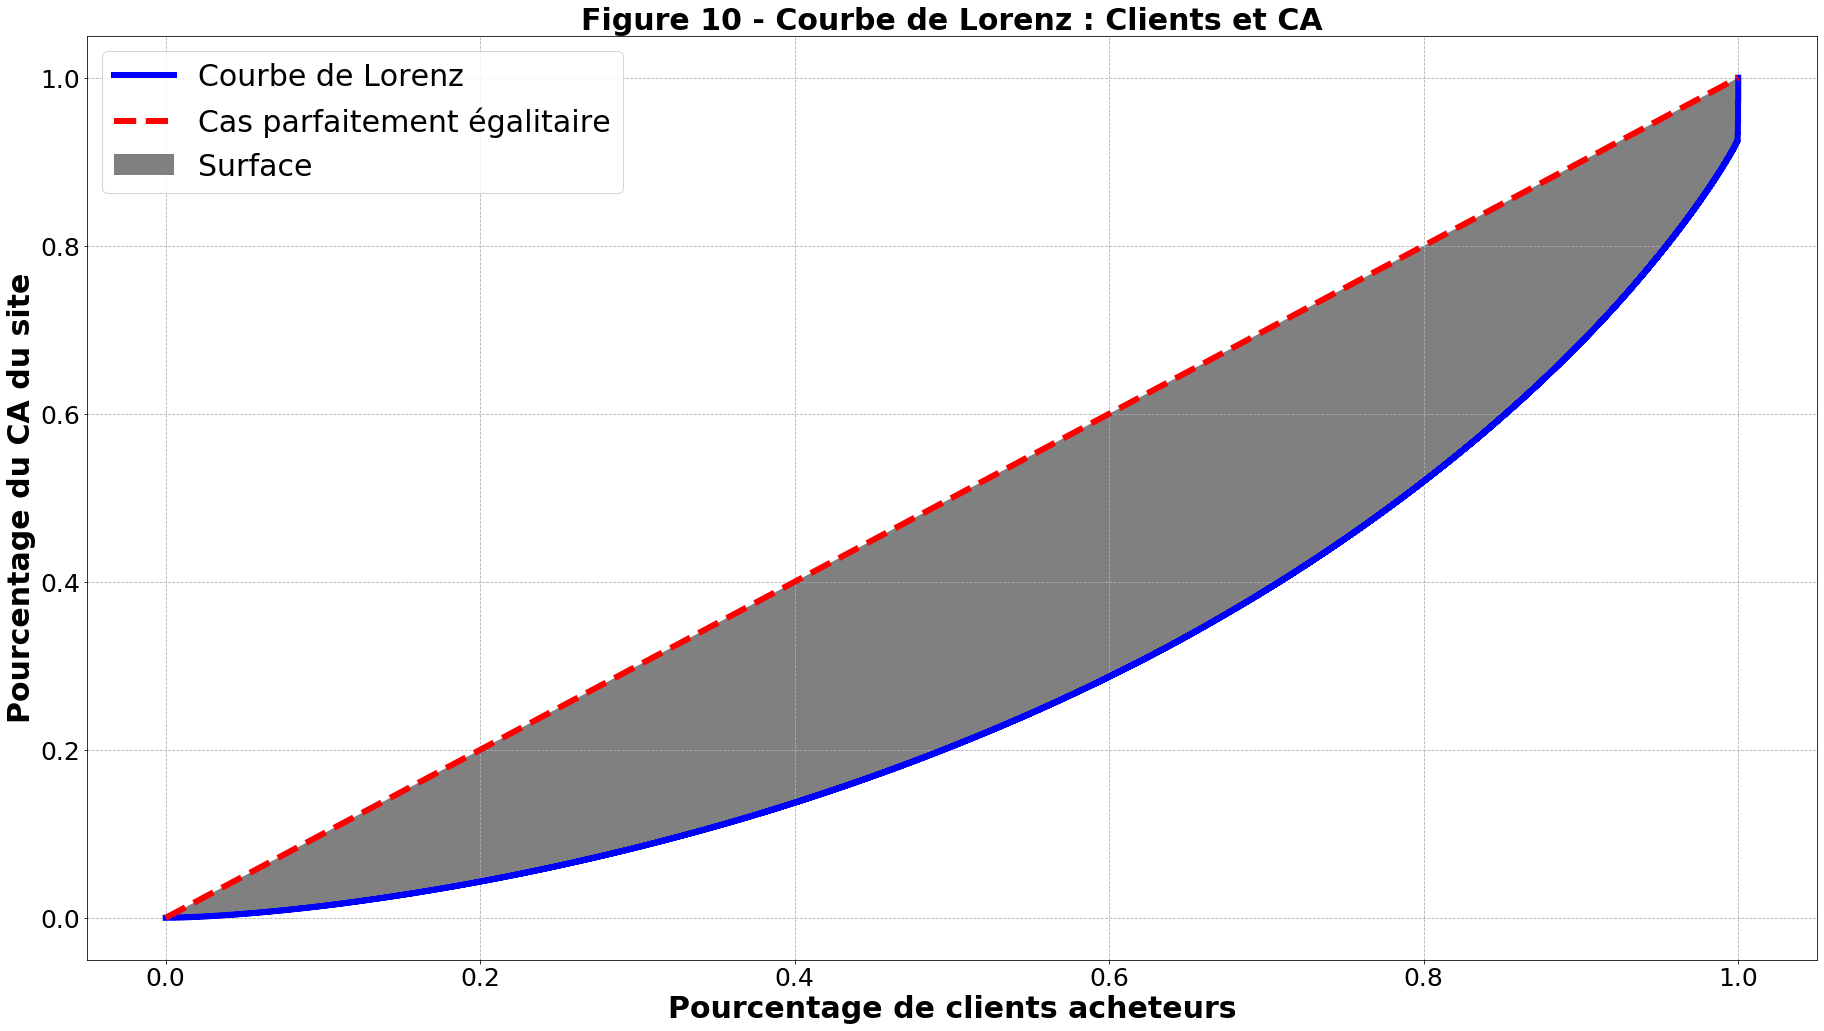

In [33]:
# CA_product_list : Chiffre d'affaires par clients
CA_client_list = np.asarray(data.groupby(["client_id"])["price"].sum().tolist())
lorenz = np.cumsum(np.sort(CA_client_list)) / CA_client_list.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
x = np.linspace(0,1,len(lorenz))

# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.plot(x,lorenz,'b',drawstyle='steps-post',linewidth=6, label='Courbe de Lorenz')
plt.plot([0,1],[0,1],'red',linestyle='--',linewidth=6, label='Cas parfaitement égalitaire')
plt.fill_between(x, x, lorenz,facecolor='grey', label = 'Surface')
plt.xlabel('Pourcentage de clients acheteurs',fontsize=30,fontweight = 'bold')
plt.ylabel('Pourcentage du CA du site',fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=30)
plt.grid(True,linestyle='--')
plt.title('Figure 10 - Courbe de Lorenz : Clients et CA',fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 10 - Courbe de Lorenz : Clients et CA.png', dpi=300)
plt.show()

In [34]:
lorenz[-5:]

array([0.92515216, 0.93454651, 0.9471756 , 0.97205703, 1.        ])

4 "super clients" génèrent 7,5% de CA.

#### Indice de Gini

L'indice de Gini correspond à l'aire entre la droite x = y et la courbe de Lorenz.

In [35]:
# Aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz)

# Aire entre la 1e bissectrice et la courbe de Lorenz
S = 0.5 - aire_ss_courbe 

# Indice de Gini
gini = 2*S
print('L indice de Gini est', round(gini,2),'.')

L indice de Gini est 0.44 .


La répartition du CA selon les clients n'est pas très égalitaire.

### <font color=#FEB229> c. Analyse des produits qui génèrent le plus de chiffre d'affaires</font> <a name="M2b"></a>

In [36]:
# CA_client : Chiffre d'affaires par produit
CA_product = data.groupby(["id_prod"])["price"].sum()
product = data.groupby(["id_prod"])["id_prod"].first()
CA_product = pd.DataFrame([a for a in zip(product,CA_product)])
CA_product.columns = ["id_prod","price"]
CA_product.sort_values(by='price', ascending=False).head(10)

id_prod     price
3070   2_135  33874.09
3045   2_112  31960.61
3034   2_102  28919.46
3152   2_209  27296.10
3043   2_110  27016.50
2591   1_369  25933.19
2619   1_395  25830.09
3104   2_166  25534.44
3206    2_43  25266.39
3201    2_39  25225.65

Les 3 produits les plus vendus sont :
- 2_135
- 2_112
- 2_102


#### Pourcentage du CA en fonction du pourcentage de produits achetés

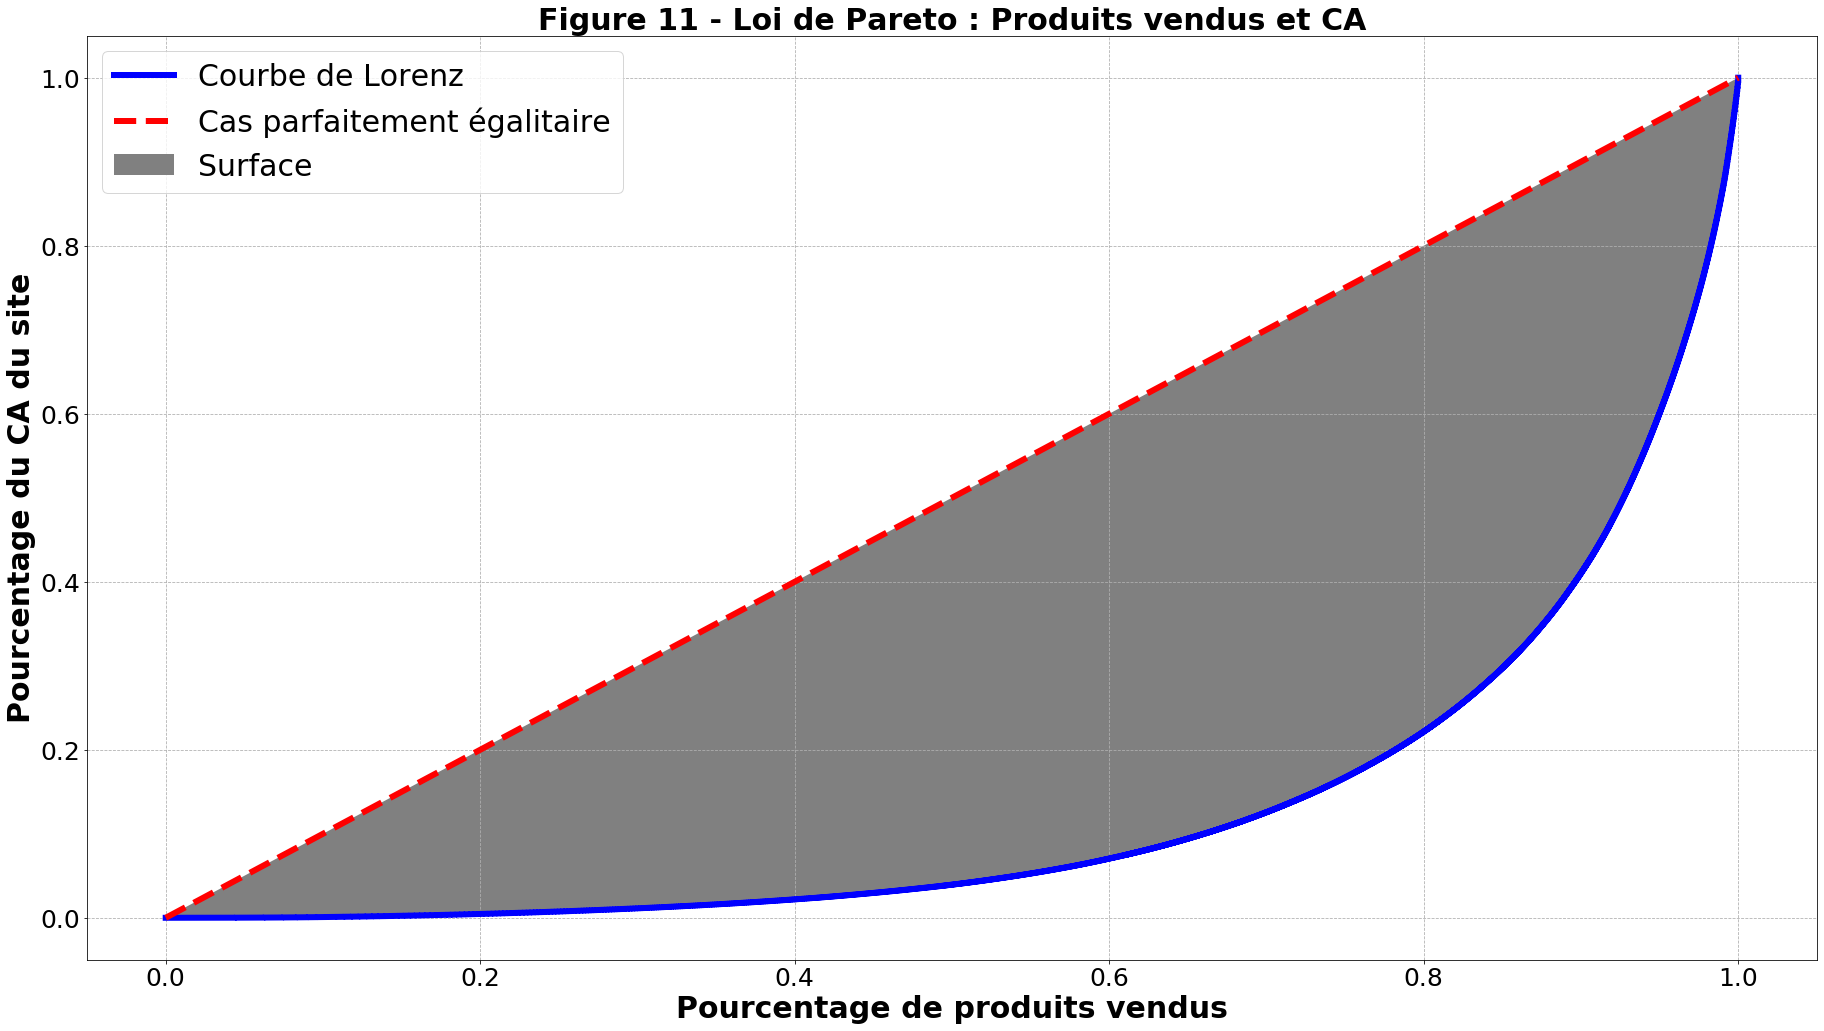

In [37]:
# CA_product_list : Chiffre d'affaires par produit
CA_product_list= np.asarray(data.groupby(["id_prod"])["price"].sum().tolist())

# lorenz : Courbe de lorenz
lorenz = np.cumsum(np.sort(CA_product_list)) / CA_product_list.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
x = np.linspace(0,1,len(lorenz))

# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.plot(x,lorenz,'b',drawstyle='steps-post',linewidth=6, label='Courbe de Lorenz')
plt.plot([0,1],[0,1],'red',linestyle='--',linewidth=6, label='Cas parfaitement égalitaire')
plt.fill_between(x, x, lorenz,facecolor='grey', label='Surface')
plt.xlabel('Pourcentage de produits vendus',fontsize=30,fontweight = 'bold')
plt.ylabel('Pourcentage du CA du site',fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=30)
plt.grid(True,linestyle='--')
plt.title('Figure 11 - Loi de Pareto : Produits vendus et CA',fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 11 - Loi de Pareto : Produits vendus et CA.png', dpi=300)
plt.show()

Loi de Pareto : 20% des produits proposés par le site génèrent 80% du CA.

#### Indice de Gini

In [38]:
# Aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz)

# Aire entre la 1e bissectrice et la courbe de Lorenz
S = 0.5 - aire_ss_courbe 

# Indice de Gini
gini = 2*S
print('L indice de Gini est', round(gini,2),'.')

L indice de Gini est 0.74 .


La répartition du CA en fonction des produits vendus est très inégalitaire (indice de Gini proche de 1).

### <font color=#FEB229> d. Analyse de la distribution des âges</font> <a name="M2b"></a>

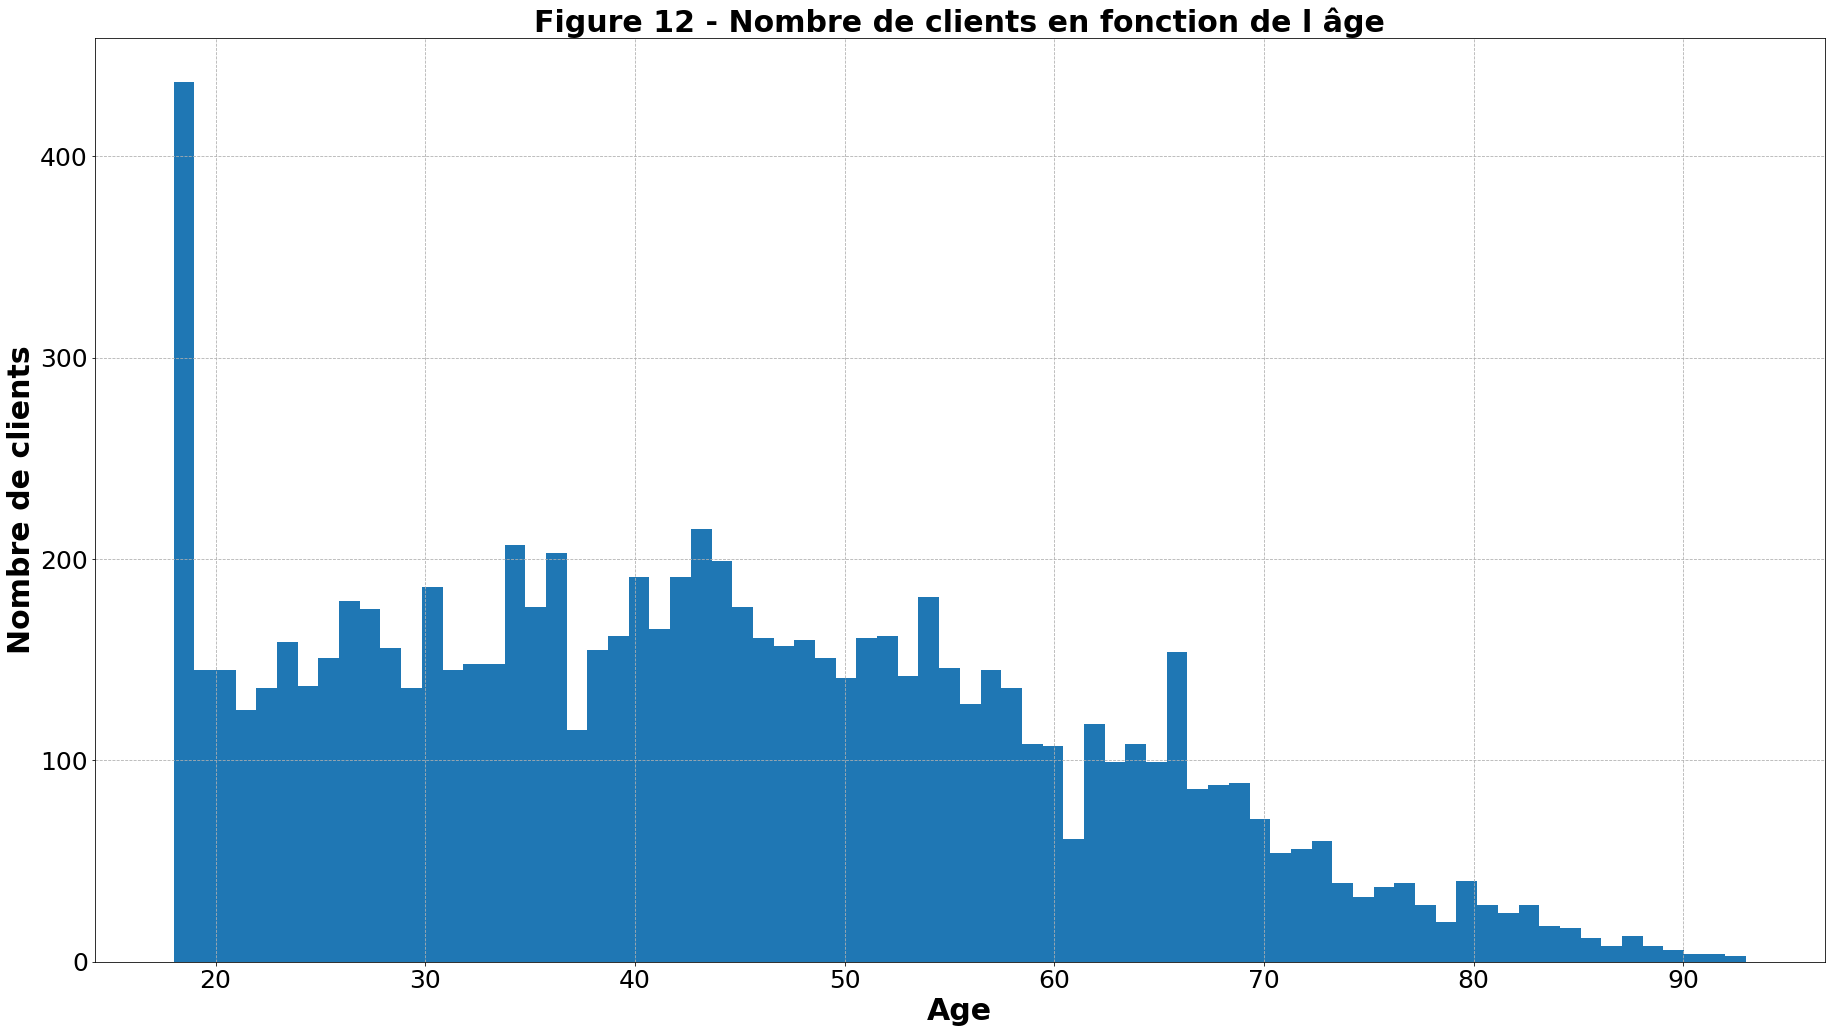

In [39]:
# distribution_age : Nombre de clients en fonction de l'âge
distribution_age = data[['client_id','age']]
distribution_age = distribution_age.drop_duplicates()

# Tracé de la figure
plt.figure(figsize = (31, 17))
plt.hist(distribution_age.age.tolist(),bins=len(data.age.drop_duplicates()))
plt.xlabel("Age",fontsize=30,fontweight = 'bold')
plt.ylabel("Nombre de clients",fontsize=30,fontweight = 'bold')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True,linestyle='--')
plt.title("Figure 12 - Nombre de clients en fonction de l âge",fontsize=30,fontweight = 'bold')
plt.savefig('figure/Figure 12 - Nombre de clients en fonction de l âge.png', dpi=300)
plt.show()
plt.close()